<a id='top'></a>
<h1 align="center">MCMC Tutorial Part 1</h1>

<br>

**Authors:** John Letey, Mingxuan Zhang, H. Nihar Nandan, and Tony E. Wong

<span style="color:red">**TW:**
This would be a great place to offer a brief overview of what this chapter is about. Just a sentence or two.
</span>

### Table of Contents

- [Packages](#packages)
- [Linear Model and Parameter Estimation](#lmpe)
- [Generate Synthetic Data](#synthetic-data)
- [Log-Likelihood Function](#log-likelihood)
- [Log-Prior Distribution](#log-prior)
- [Log-Posterior Distribution](#log-posterior)

<a id='packages'></a>
***
<h2 align="center">Packages</h2>
[Back to top](#top)

<br>

These are all of the packages we are going to be using:

In [1]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")
# %load_ext blackcellmagic

***

<a id='lmpe'></a>
***
<h2 align="center">Linear Model and Parameter Estimation</h2>
[Back to top](#top)

<br>

<!-- In a real world application, we would have some observations of a system. In this tutorial, we will instead fit a two parameter **linear model** to some pseudo observations that we generate. We choose this approach to reduce the complexity of learning and understanding MCMC. It is also useful in understanding the assumptions made according to the structure of the observations. (**This part was adapted from MCMC chapter1**). -->

Let's say we have a linear model that simulates the amount of ice cream you will consume (where $y$ has units of pints) after going on a bike ride of length $x$ (where $x$ has units of miles). So the true process model, based on the unknown true values of the slope and intercept parameters, which we can call $\alpha^*$ and $\beta^*$, is:

$$y_{true} = \alpha^*x  +  \beta^*$$

We want to make this more realistic by incorporating some normally-distributed uncertainty, for instance, with mean $0$ and standard deviation $\sigma$.  Call these uncertain measurements $y_{meas}$:

$$y_{meas} = y_{true}  +  \epsilon = \alpha^*x  + \beta^*  +  \epsilon$$

where $\epsilon \sim N(0, \sigma)$ is our normally-distributed measurement error. We now want to estimate $\alpha$ and $\beta$. Let us call $\hat{\alpha}$ and $\hat{\beta}$ our estimates of these parameters. They lead to a set of estimates of the response, $\hat{y}$:

$$\hat{y} = \hat{\alpha}x  +  \hat{\beta}$$

This is then a parameter estimation problem, where our task is to compute estimates, $\hat{\alpha}$ and $\hat{\beta}$, of the unknown true model parameters, $\alpha^*$ and $\beta^*$, such that our model $\hat{y}$ best represents the observations $y_{meas}$, in light of the uncertainties $\epsilon$. We will tackle this problem through **Bayesian model calibration**, wherein we will integrate possible prior knowledge regarding the parameters with the information from observational data.
***

<a id='synthetic-data'></a>
***
<h2 align="center">Generate Synthetic Data</h2>
[Back to top](#top)

<br>

We will generate some synthetic data using our linear model, as described above, in order to demonstrate the Bayesian calibration approach. Suppose we keep track of our ice cream consumption after 100 bicycle rides, varying in length (uniformly) between 0 and 10 miles. For each of these ride lengths, we can use the linear model above to estimate the true ice cream consumption for each ride, and then add in the Gaussian residuals $\epsilon$. In this particular case, let $\alpha^* = 0.5$ and $\beta^* = 8$, which represent the true parameters for our linear model.

<span style="color:red">**TW:**
Let's add a sentence interpreting the true physical process model going on here. That is, for every additional mile we bike, we consume ... ice cream and ... baseline ice cream consumption...
</span>

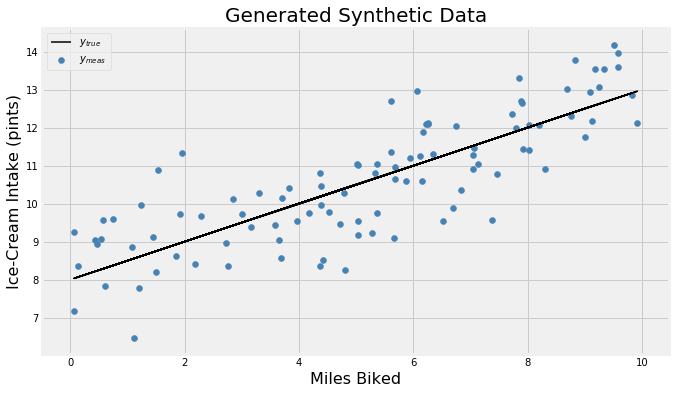

In [2]:
def generate_synthetic_data(astar, bstar, sigma, random_seed=1234, plot=False):
    np.random.seed(random_seed)  # set the seed for sampling.
    # the x values.
    x = np.random.uniform(0, 10, size=100)
    # the true y values.
    y_true = [astar * x_ + bstar for x_ in x]
    # the synthetic y values.
    y_meas = [stats.norm.rvs(loc=y, scale=sigma) for y in y_true]
    # plot if the user wants to
    if plot:
        plt.figure(figsize=(10, 6))
        plt.plot(x, y_true, lw=1.5, color="k", label=r"$y_{true}$")
        plt.scatter(x, y_meas, color="steelblue", label=r"$y_{meas}$")
        plt.title("Generated Synthetic Data", fontsize=20)
        plt.xlabel("Miles Biked", fontsize=16)
        plt.ylabel("Ice-Cream Intake (pints)", fontsize=16)
        plt.legend()
        plt.show()
    # return the generated data
    return np.array(x), np.array(y_true), np.array(y_meas)


x, y_true, y_meas = generate_synthetic_data(astar=0.5, bstar=8, sigma=1, plot=True)

***

<a id='log-likelihood'></a>
***
<h2 align="center">Log-Likelihood Function</h2>
[Back to top](#top)

<br>

The likelihood function describes the plausibility of a parameter value based on observations. Generally, we seek parameter values that maximize the likelihood function. For this example, since we know that the observed-true y residuals are normally distributed with mean $0$ and standard deviation $\sigma$, we will use the product of normal distributions for each observed-true y residuals to represent the likelihood function:

<span style="color:red">**TW:**
residuals need to be **independent** too
</span>

$$L(y_{meas} \mid (\hat{\alpha}, \hat{\beta})) = \prod_{i=1}^N f(\hat{y}_i-y_i \mid \mu=0, \sigma)$$

where $f(\hat{y}_i-y_i \mid \mu, \sigma)$ is a normal pdf evaluated at $\hat{y}_i - y_i$, with mean $\mu=0$ and standard deviation $\sigma$, and $\hat{y} = \hat{\alpha} x + \hat{\beta}$ (evaluated at the `x_true` points).

<span style="color:red">**TW:**
yhat is alpha-hat x + betae-hat (I fixed it)
</span>

In this analysis, you will work with the **log-probability distributions** for numerical stability reasons. That is, the probabilities involved may be very small, and computers may not be able to distinguish them from 0 in many cases.
<br>

<span style="color:red">**TW:**
Let's include an equation with the log-likelihood, to show it as a sum
</span>

<span style="color:red">**TW:**
Below, the function uses the equation for a normal pdf, and expands it when taking the log. We should  show the full normal pdf in the likelihood and log-likelihood equations before it shows up in the function, sort of out of nowhere. Alternatively, call the scipy.stats.norm.pdf function (and add a sentence saying that we'll do that)
</span>

In [3]:
def loglikelihood(theta, y, sigma=1):
    N = len(y)
    alpha, beta = theta[0], theta[1]
    model = alpha * x + beta
    resid = y - model
    log_likelihood = (
        -N / 2 * np.log(2 * np.pi)
        - N * np.log(sigma)
        - 1 / 2 * sum(resid ** 2) / sigma ** 2
    )
    return log_likelihood

***

<a id='log-prior'></a>
***
<h2 align="center">Log-Prior Distribution</h2>
[Back to top](#top)

<br>

The prior distribution is the probability of an event or observation, before taking into account the evidence. For this example, we will use a uniform prior distribution for $\alpha$ and $\beta$. Here, we will assume that $\alpha$ and $\beta$ are independent, so their prior distribution simplifies to $\pi(\alpha, \beta) = \pi(\alpha) \pi(\beta)$. But similarly to likelihood, we should build up the log-prior, so $\log(\pi(\alpha, \beta)) = \log(\pi(\alpha)) + \log(\pi(\beta))$.

To use uniform distribution, we need upper bound and lower bound to define the pdf, so the upper and lower bounds for $\alpha$ are 100 and 0 and the bound for $\beta$ are also 100 and 0.

<span style="color:red">**TW:**
Have we defined the abbreviation "pdf" yet? Check above. If not, here we should say "probability density function (pdf)"
</span>

<span style="color:red">**TW:**
Include a sentence noting that these bounds may be unrealistically wide, but we want to illustrate that this procedure still works even if we have weak prior knowledge (or "relatively uninformative" priors)
</span>

<span style="color:red">**TW:**
When you talk about the likelihood function and prior, make a note somewhere that there are maximum likelihood methods, but hte strength of a *bayesian* model calibratoin approach is to use the likelihood function *AND* incorporate any prior knowledge
</span>

So the prior distribution will be;
$$\log(\pi(\alpha, \beta)) = \log(\pi(\alpha)) + \log(\pi(\beta)) = \log\left(\dfrac{1}{100}\right) + \log\left(\dfrac{1}{100}\right) $$

<span style="color:red">**TW:**
prior ought to be a piecewise function that is 1/100 only between 0 and 100, and 0 outside that range. for example:

$$\pi(\alpha) = \begin{cases} \dfrac{1}{100} & \text{if}~0 \leq \alpha \leq 100 \\ 0 & \text{otherwise} \\ \end{cases}$$
</span>

<span style="color:red">**TW:**
FYI:  I changed the parentheses on the logs above to be the ones that will match the size of whatever they surround: \left( and \right)
</span>

In [4]:
def logprior(theta):
    alpha, beta = theta
    if alpha < 0 or alpha > 100 or beta < 0 or beta > 100:
        return -np.inf
    else:
        return np.log(1 / 100) + np.log(1 / 100)

***

<a id='log-posterior'></a>
***
<h2 align="center">Log-Posterior Distribution</h2>
[Back to top](#top)

<br>

The posterior distribution is defined as being the probability that an event or observation will occur after taking into account all evidence and background (i.e., prior) information, in light of the uncertainties in both the parameters and the observations. Bayes' theorem defines the posterior probability as proportional to the likelihood of the observations given the parameters times the prior probability of the parameters:

$$\text{posterior distribution} = \pi((\alpha, \beta) \mid y_{meas}) \propto L(y_{meas} \mid (\alpha, \beta)) \times \pi(\alpha, \beta)$$

where $L(y_{meas} \mid (\alpha, \beta))$ is the likelihood function and $\pi(\alpha, \beta)$ is the prior distribution for alpha and beta.

The posterior distribution summarizes information about the parameters based on the prior distribution and what the likelihood function says about more "likely" parameter values.

<span style="color:red">**TW:**
put a comment or two into the code below saying what all is going on. especially to point out the possible inefficiency of executing the likelihood function in situations where the prior probability is 0 (lprior=-inf)</span>


In [5]:
def logpost(theta, y, sigma=1):
    lprior = logprior(theta)
    if lprior == -np.inf:
        return -np.inf
    ll = loglikelihood(theta, y, sigma)
    return ll + lprior

***

## Markov Chains

<span style="color:red">**TW:**
follow same h2 centered heading  throughout if that's what is being used
</span>

A Markov chain is a stochastic model describing a sequence of possible events in which the probability of each event depends only on the state attained in the previous event. 

Let's begin with one simple example to introduce the basic idea of markov chains. Suppose the $X_{n}$ is the weather condition on day $n$ in Boulder, CO, which is either $0 \Rightarrow \text{rainy}$, or $1 \Rightarrow \text{sunny}$. Suppose we know that if the current day is sunny then the probability that the following day is also going to sunny is $0.9$, and if the current day is rainy then the probability that the following day is also going to be rainy is $0.3$. Thus, we have four transititon probailities:

$$
\begin{aligned}
P(X_{n+1} = 1 \mid X_{n} = 1) &= 0.9 \\
P(X_{n+1} = 1 \mid X_{n} = 0) &= 1- 0.9 = 0.1 \\
P(X_{n+1} = 0 \mid X_{n} = 0) &= 0.3 \\
P(X_{n+1} = 0 \mid X_{n} = 1) &= 1- 0.3 = 0.7
\end{aligned}
$$

At this point in time, you might be wondering what is the probability that day $n+1$ is sunny given we know all the weather conditions from day $0$ to $n$. This can be represented by the probability

$$ P(X_{n+1} = 1 \mid X_{n}, X_{n-1}, X_{n-2}. ......., X_{0}) = ? $$

Fortunately, since we have the four transition probailities, we only need to know the weather condition at day $n$ to obtain that specific probability. Therefore, any other information about the past is irrelevant for predicting $X_{n+1}$, thus:

$$ P(X_{n+1} = 1 \mid X_{n}, X_{n-1}, X_{n-2}. ......., X_{0}) = P(X_{n+1} = 1 \mid X_{n}) $$

This is what we mean when we say "the probability of each event depends only on the state attained in the previous event."

<span style="color:red">**TW:**
use the phrase "conditionally independent, given $X_n$" or something like that, instead of "irrelevant" (irrelevant sounds kind of harsh and dismissive)
</span>

<span style="color:red">**TW:**
Include definition of the (first-order) Markov property when discussing this independnence
</span>

## Metropolis-Hastings Algorithm

<span style="color:red">**TW:**
centered?
</span>

Now, let's go back to the linear model and parameter estimation problem: our goal is to find the good parameters for this ice cream consumption model. One of the ways we can do this is by using the Metropolis-Hastings algorithm and markov chains:

The Metropolis-Hastings algorithm will help us find good parameters and save them (our log-posterior function can tell us how good are they), if it is better than the current one, we will accept it and use the parameters we accepted as our next starting point to explore more parameters with a fixed step size. However, if it isn't better, we still can accept it with some probability ... intuitively, if the proposed parameters are really bad (low log-posterior score) we want the acceptance probability to be low too. If they are close to our current parameters, we want the the acceptance probability to be higher. We can do that by carefully using our log-posterior function to save all the parameters we accepted. When the algorithm ends, we will have a long markov chain! Below is a rough sketch of the Metropolis-Hastings algorithm:


> **Metropolis-Hastings Algorithm (MCMC):**
  * save **all** of the previous parameter states so that they can tell you something about your system
  * probability of accepting a move at iteration $t$ is the ratio of the **posterior scores** for the current and the proposed states:
  $$p_{accept} = min\left(\dfrac{\pi(\alpha_{new}, \beta_{new} \mid y_{meas})}{\pi(\alpha_{t}, \beta_{t} \mid y_{meas})}, 1\right)$$
  where $\pi(\alpha \mid y_{meas})$ is the posterior score for the parameter value $\alpha$, given the data.
    * if we accept the proposed move, then the next $\alpha_{t+1}$ is set to $\alpha_{new}$
    * if we reject the proposed move, then the next $\alpha_{t+1}$ is set to $\alpha_t$ (no change)
  * do this for some large number $N$ of iterations ($t=0, 1, 2, \ldots, N$)

<br>

<span style="color:red">**TW:**
Haha... okay, split the difference.  We certainly still want to include steps like "Start with some initial parameter estiamtes $\alpha_0$ and $\beta_0$"...  and the random draw of new parameters $\alpha_{new}$ and $\beta_{new}$...
</span>

### Stationary Distribution

Todo...  review the fact that if you choose your transition probabilities (acceptance probabilities) in THIS special way, then the stationary distribution just happens to be the posterior distribution of your model parameters!

<span style="color:red">**TW:**
Describing this in your own words, not quotations from any textbook or what not.
</span>

<span style="color:red">**TW:**
the code below can be used to inform how the pseudocode for the algorithm looks above. Make sure the two run parallel to one another, and include plenty of comments!
</span>

<span style="color:red">**TW:**
Introduce concept of the proposal step sizes, and the "Goldilocks" notion of what is ideal (44% for a single parameter, 23.4% as the number of parameters goes to infinity; someone besides John should dig up the references for these, which are probably in my GMD BRICK paper)
</span>


In [6]:
def MCMC_chains(y, step, N=30_000):
    # randomly generate starting positions.
    alpha_init = np.random.randint(low=0, high=1)
    beta_init = np.random.randint(low=0, high=10)
    theta = [alpha_init, beta_init]
    # set variables.
    lp = logpost(theta, y)
    theta_best = theta
    lp_max = lp
    theta_new = [0] * 2
    accepts = 0
    mcmc_chains = [[0, 0]] * N
    # run the mcmc chain.
    for i in range(N):
        theta_new = list(stats.multivariate_normal.rvs(theta, step))
        lp_new = logpost(theta_new, y)
        lq = lp_new - lp
        lr = np.log(np.random.uniform(0, 1))
        if lr < lq:
            theta = theta_new
            lp = lp_new
            accepts += 1
            if lp > lp_max:
                theta_best = theta
                lp_max = lp
        mcmc_chains[i] = theta
    mcmc_chains = np.array(mcmc_chains)
    # print the acceptance ratio.
    ar = (accepts / N) * 100
    print(f"Acceptance Rate ≈ {ar:.4f}%")
    # return the mcmc chain.
    return mcmc_chains

In [7]:
def plot_chains(mcmc_chains, N=30_000):
    # History Plots
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 4))
    fig.tight_layout()
    ax[0].plot([-25, N + 25], [0.5, 0.5], ls="--", lw=3.5, color="#800000")
    ax[0].plot(mcmc_chains[:, 0], lw=0.50, color="gray")
    ax[0].set_title("History Plots", fontsize=16)
    ax[0].set_ylabel(r"$\alpha$", fontsize=16)
    ax[1].plot([-25, N + 25], [8, 8], ls="--", lw=3.5, color="#800000")
    ax[1].plot(mcmc_chains[:, 1], lw=0.50, color="steelblue")
    ax[1].set_ylabel(r"$\beta$", fontsize=16)
    plt.show()
    # Theta Histogram
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
    fig.tight_layout()
    ax[0].hist(mcmc_chains[:, 0], 50, color="k", histtype="step")
    ax[0].plot(
        [0.5, 0.5],
        [0, max(np.histogram(mcmc_chains[:, 0], 50)[0])],
        ls="--",
        lw=1.5,
        color="#800000",
    )
    ax[0].set_xlabel(r"$\alpha$", fontsize=16)
    ax[0].set_ylabel("Density", fontsize=16)
    ax[0].set_yticks([])
    ax[1].hist(mcmc_chains[:, 1], 50, color="k", histtype="step")
    ax[1].plot(
        [8, 8],
        [0, max(np.histogram(mcmc_chains[:, 1], 50)[0])],
        ls="--",
        lw=1.5,
        color="#800000",
    )
    ax[1].set_xlabel(r"$\beta$", fontsize=16)
    ax[1].set_ylabel("Density", fontsize=16)
    ax[1].set_yticks([])
    plt.show()

<span style="color:red">**TW:**
Introduce what these plots are -- the very zoomed out history plots are not particularly useful, so zoom those WAY in. This might require you to narrow the prior range, which is totally fine too. </span>

<span style="color:red">**TW:**
histograms can be a bit smaller, and the trace plots can be correspondingly less wide
</span>

Acceptance Rate ≈ 61.2767%


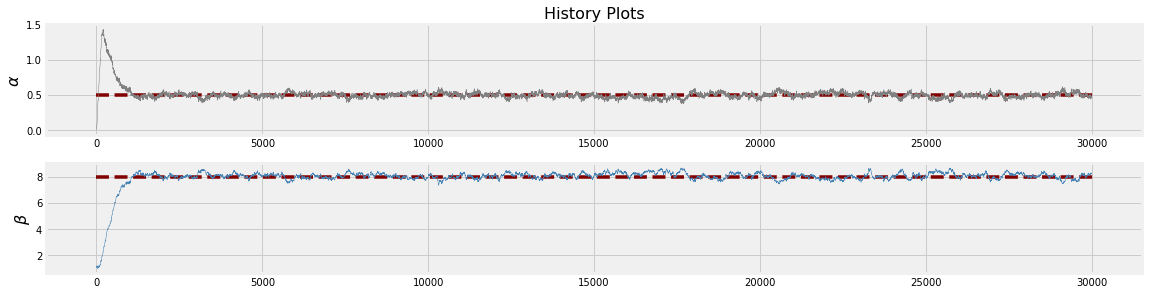

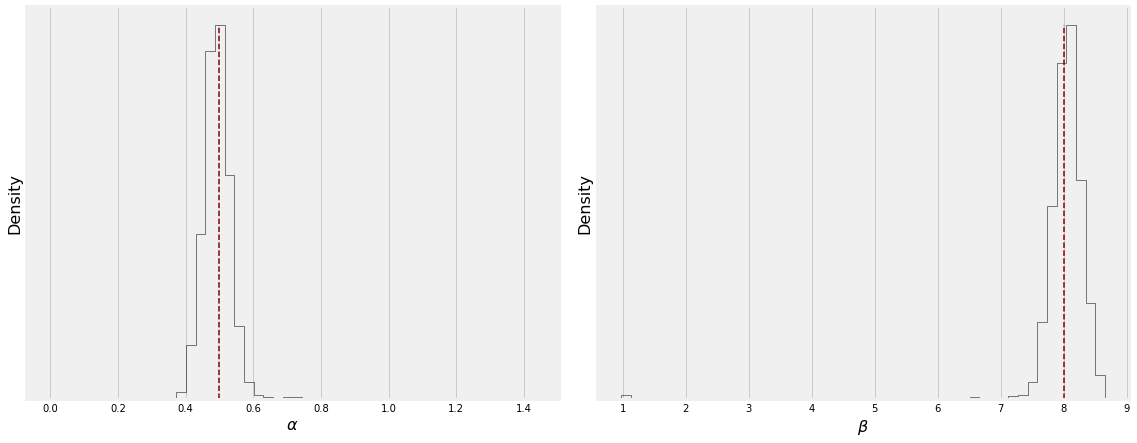

In [8]:
mcmc_chains = MCMC_chains(y_meas, step=[.0005, .001])
plot_chains(mcmc_chains)

<span style="color:red">**TW:**
Can't really see the trace plot because the dashed line for the true parameters is so thick and the view is so zoomed out.  Try to fix this so we can see everything. You could also just get rid of the dashed line for the true parameters in the history plots, but keep it in the histograms.
</span>

Acceptance Rate ≈ 0.9900%


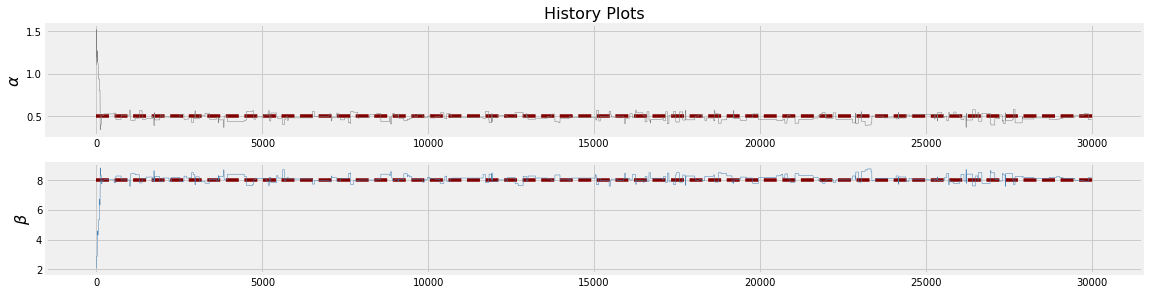

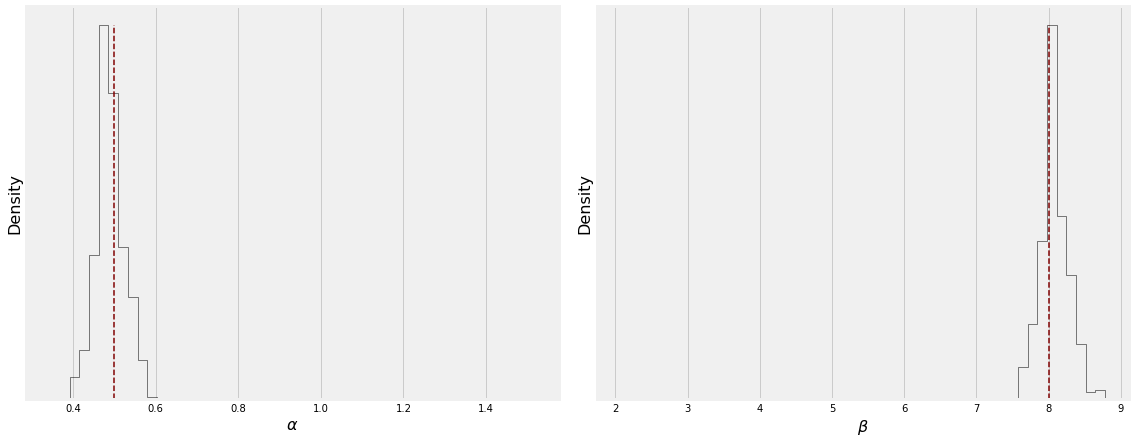

In [9]:
mcmc_chains = MCMC_chains(y_meas, step=[.5, .9])
plot_chains(mcmc_chains)

Acceptance Rate ≈ 26.6000%


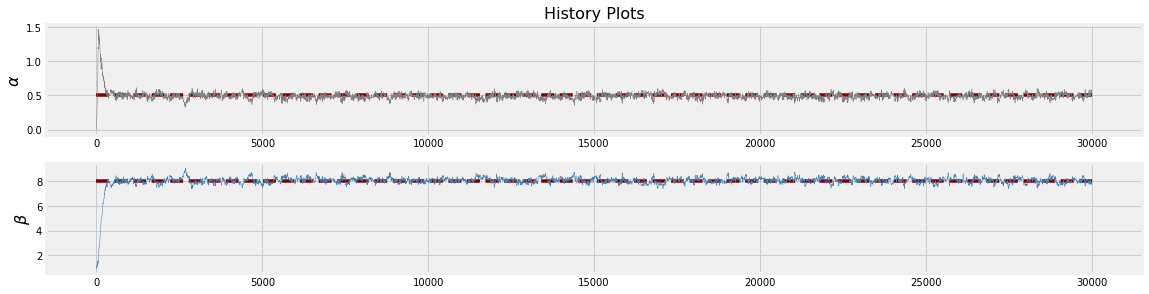

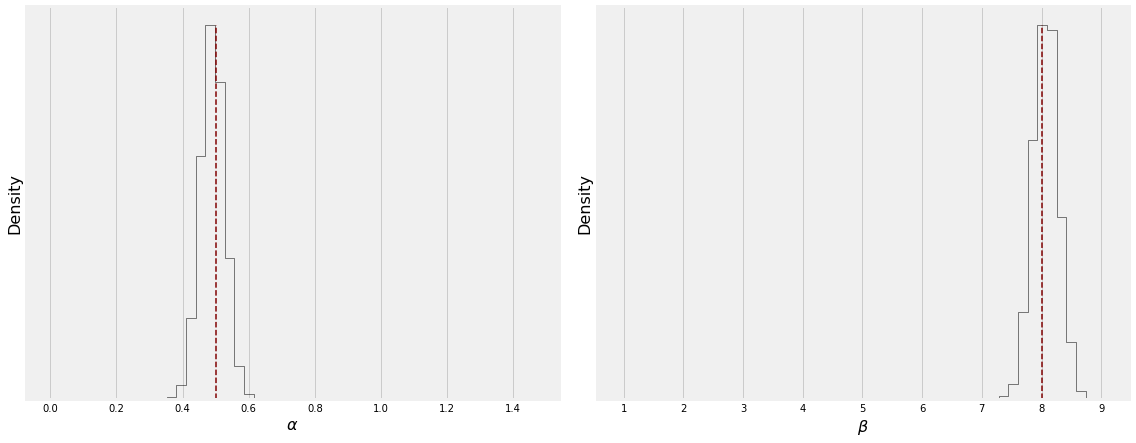

In [10]:
mcmc_chains = MCMC_chains(y_meas, step=[0.005, 0.01])
plot_chains(mcmc_chains)

## Convergence/Stationarity Diagnostics

<span style="color:red">**TW:**
header...
</span>

We want the Markov chains to reach the stationary distribution, but how can we tell whether they are in the stationary distribution? Fortunately, the Gelman and Rubin diagnostic assesses this using something called the "potential scale reduction factor". The potential scale reduction factor monitors the variance within the chain and compares it against the variance between the chains and if they look similar. If they are similar, then this is evidence for convergence. It is necessary to estimate the “between-chain variance”, so you need to run at least one additional MCMC calibration to estimate the potential scale reduction factor. 

<span style="color:red">**TW:**
add a reference to Gelman and Rubin (1992)
</span>

</n>

The algorithm for the Gelman-Rubin Diagnostic is as follows:

<span style="color:red">**TW:**
do we need to include this algo image?
</span>

![](figs/gelman_rubin_diag.png)

The equation for the diagnostic is:
$$
R = \frac{\hat{V}}{\sigma^2} \cdot \frac{df}{df-2}
$$

<span style="color:red">**TW:**
HERE is where you need to define what all the quantities in that equation are (always, right after or before you introduce them) $$$$
Also -- I changed the period in the equation above to \cdot
</span>

<span style="color:red">**TW:**
Turns out, Gelman and Rubin (1992) even say outright that "We ignore the minor contribution to variability in the factor df/(df-2)". So, I edited below to reflect this.</span>

For the purposes of our tutorial, we will follow Gelman and Rubin (1992) and ignore the minor contribution of the degrees of freedom correction $df/(df-2)$. So our diagnostic will be calculated as
$$
R = \frac{\hat{V}}{\sigma^2}
$$

The squared scale $\hat{V}$ is given by
$$
\hat{V} = \hat{\sigma}^2 + \frac{B}{mn} \quad\text{and}\quad \hat{\sigma}^2 = \frac{n-1}{n}W + \frac{1}{n}B
$$

The remaining variables above can be caluclated as

$$
\begin{align*}
m &= \text{number of sequences} \\
n &= \text{length of each chain} \\
B &= \frac{n}{(m - 1)}.\Sigma(\mu_i - \bar{\mu})^2, ~~
\text{where $\mu_i$ is the average of each chain and $\bar{\mu}$ is the global mean of all estimated variables} \\
W &= \frac{1}{m}.\Sigma{\textrm{Var}_i}, ~~
\text{which is the average of the variances of the chains} \\
\end{align*}
$$

<span style="color:red">**TW:**
Have you defined what $\textrm{Var}_i$ is yet?
</span>


<span style="color:red">**TW:**
add some comments to the `diagnostic` function, to describe what each thing is in terms of the variables above
</span>

In [10]:
mcmc_chains = []
N = 30000
m = 10
for i in range(m):
    mcmc_chains.append(MCMC_chains(y=y_meas, step=[0.005, 0.01], N=N))
mcmc_chains = np.array(mcmc_chains)


def diagnsotic(mcmc_chains):
    m = len(mcmc_chains)
    s_j = [np.var(mcmc_chains[i]) for i in range(m)]
    W = 1 / m * np.sum(s_j)
    global_mean = np.mean([np.mean(mcmc_chains[i]) for i in range(m)])
    B = (
        N/(m - 1)
        * np.sum([(np.mean(mcmc_chains[i]) - global_mean) ** 2 for i in range(m)])
    )
    Var = (1 - 1 / N) * W + 1 / N * B
    return np.sqrt(Var / W)


R = [(diagnsotic(mcmc_chains[:, 0, :]))]
burn_in = 1
while burn_in < 10000:
    R.append(diagnsotic(mcmc_chains[:, :burn_in, :]))
    burn_in += 100
R.append(diagnsotic(mcmc_chains[:, burn_in:, :]))

Acceptance Rate ≈ 26.0200%
Acceptance Rate ≈ 25.8967%
Acceptance Rate ≈ 26.2967%
Acceptance Rate ≈ 25.9833%
Acceptance Rate ≈ 26.2133%
Acceptance Rate ≈ 26.2633%
Acceptance Rate ≈ 26.0167%
Acceptance Rate ≈ 26.6000%
Acceptance Rate ≈ 26.3700%
Acceptance Rate ≈ 26.0533%


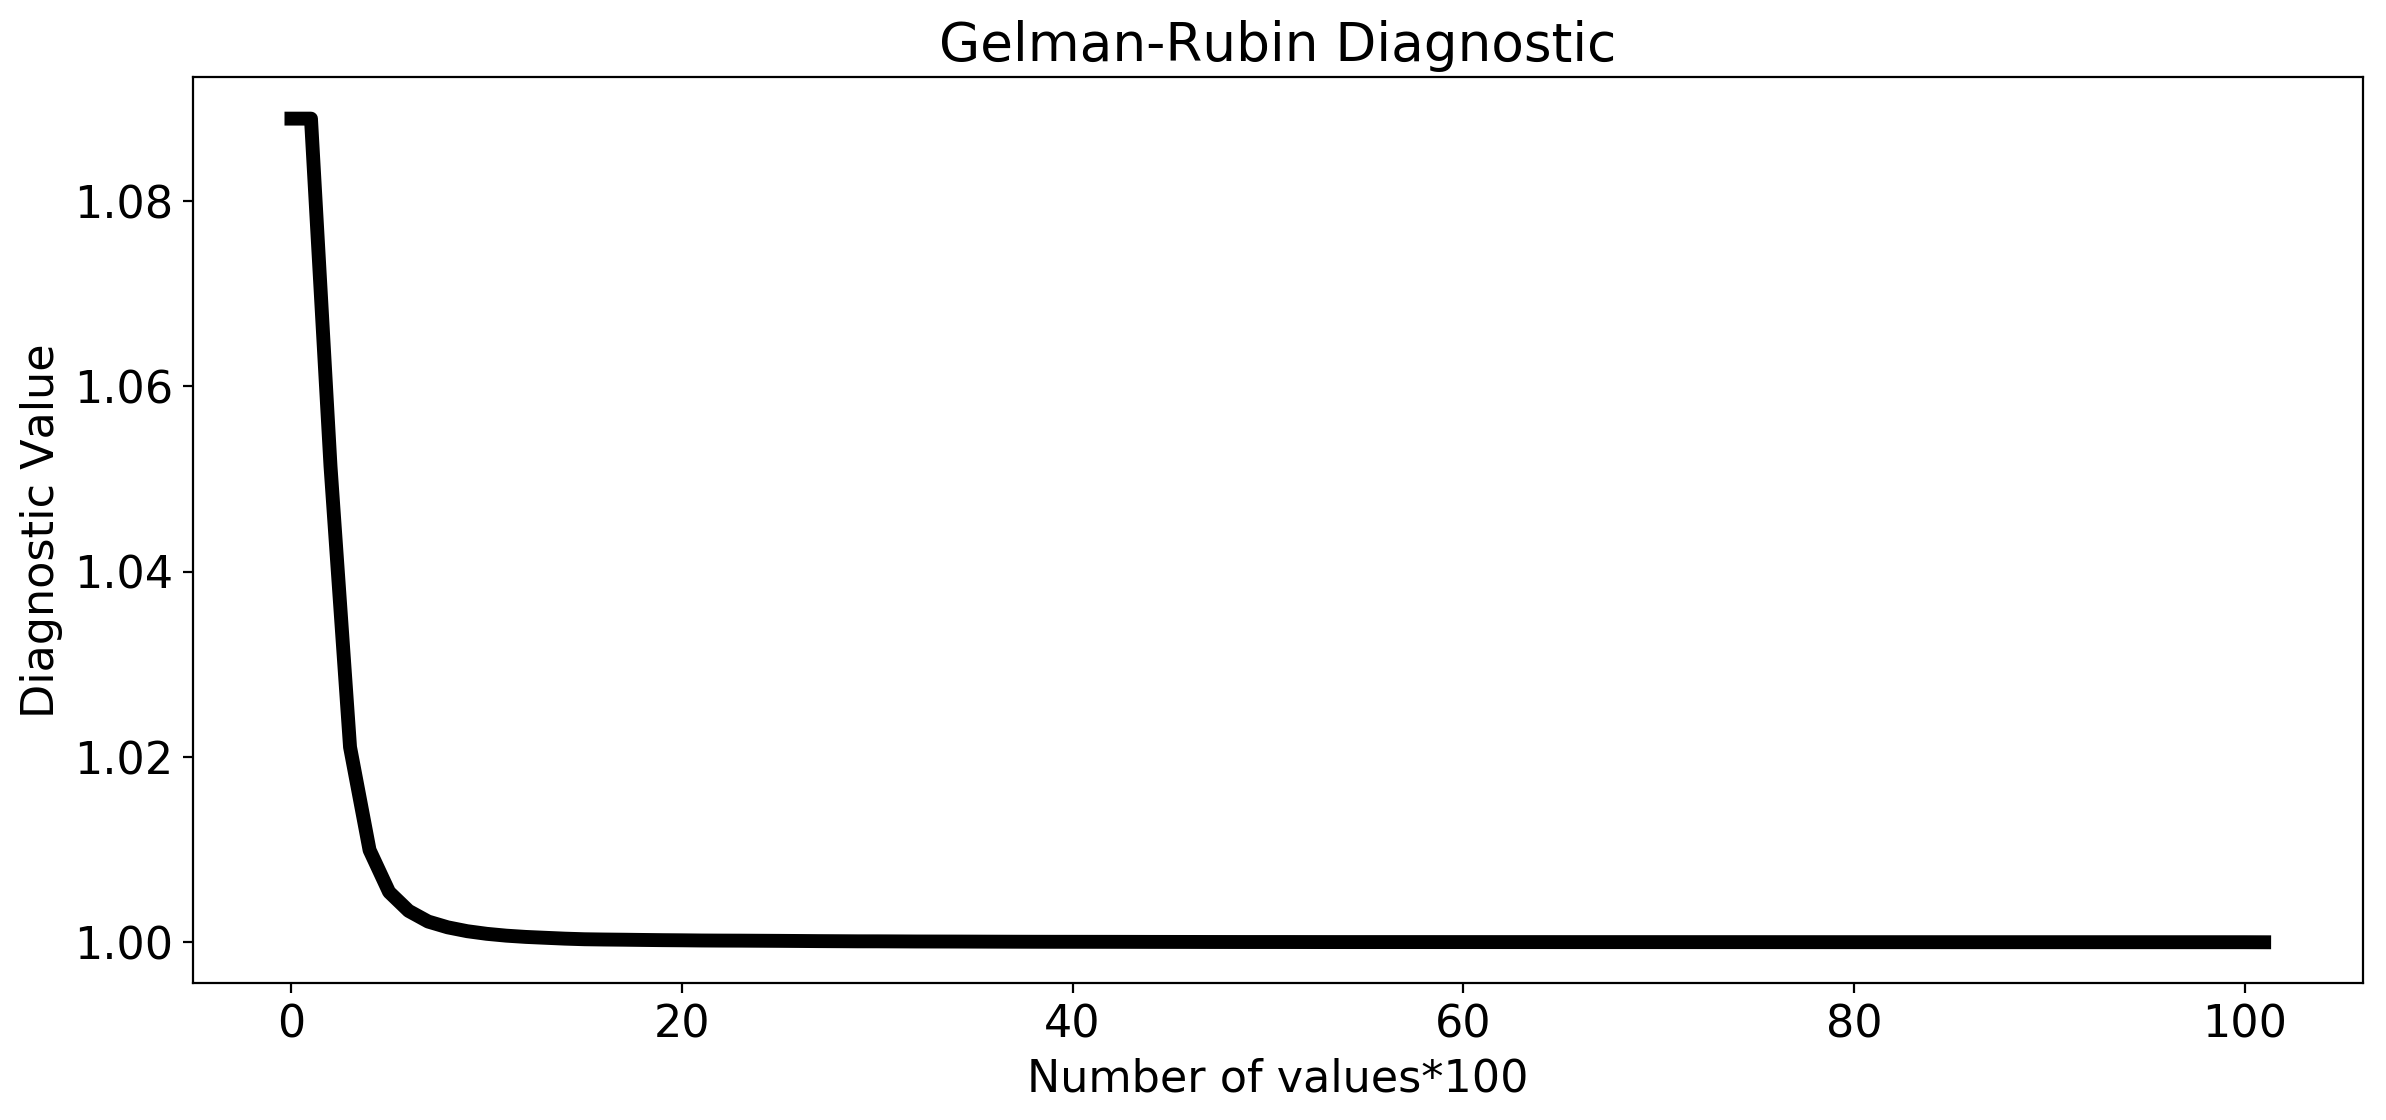

In [11]:
_, ax = plt.subplots(figsize=(14, 6))
ax.plot(R, color="k", lw=5);
ax.set_title("Gelman-Rubin Diagnostic");
ax.set_xlabel("Number of values*100");
ax.set_ylabel("Diagnostic Value");

<span style="color:red">**TW:**
What is number of values \* 100? 20 would then be 0.2 values...?  And we certaintly do not need to show such a wide x-range.  Only going out to 10 or 20 is probably fine because we only care about getting GR under 1.1. $$$$
Should show the **actual** number of simulations along the x-axis, and call the y-axis "Potential scale reduction factor"
</span>


## Thinning



Now that we have determined whether or not our chains have burnt-in and where each chain has burnt in, now we can thin down our values to estimate our parameters. We can do this by calculating something known as the ```auto-correlation``` value which tells how dependent values are. We want our correlation to be low which tells us that the values are relatively independent. 

<span style="color:red">**TW:**
The logical flow is not quite right here.  We should start the section with our motivation: we want independent samples.  So, we look at autocorrelation.  We want autocorrelation to be low, because that means samples within the Markov chain aren't correlated with one another beyond that lag. So try to clean and tighten up the paragraphs above and below here to reflect that.
</span>

<span style="color:red">**TW:**
when defining autocorrelation, be sure to mention that this is the correlation of the time series with itself, but offset by a certain number of tiem steps -- aka, the `lag`
</span>


By taking different intervals of values and calculating the correlation, we want to minimize this gap for independent values which is our ```lag```. The correlation has to be calculated for each parameter in every chain, so if we have more parameters, it will start to become compututationally expensive, but the amount of time it will save compared to just using all the values across our chains will be significant. We also want (relatively) independent values for any estimation.

In [12]:
def ACF(X, end=200, interval=1, plot=False):
    N = len(X)
    acf = []
    x_range = []
    for a in range(0, end, interval):
        x_range.append(a)
        acf.append(np.corrcoef(X[a:], X[: N - a])[0][1])
    if plot:
        _, ax = plt.subplots(figsize=(8, 6))
        ax.stem(x_range, acf)
        ax.set_xlabel("Lag")
        ax.set_ylabel("ACF")
    return acf

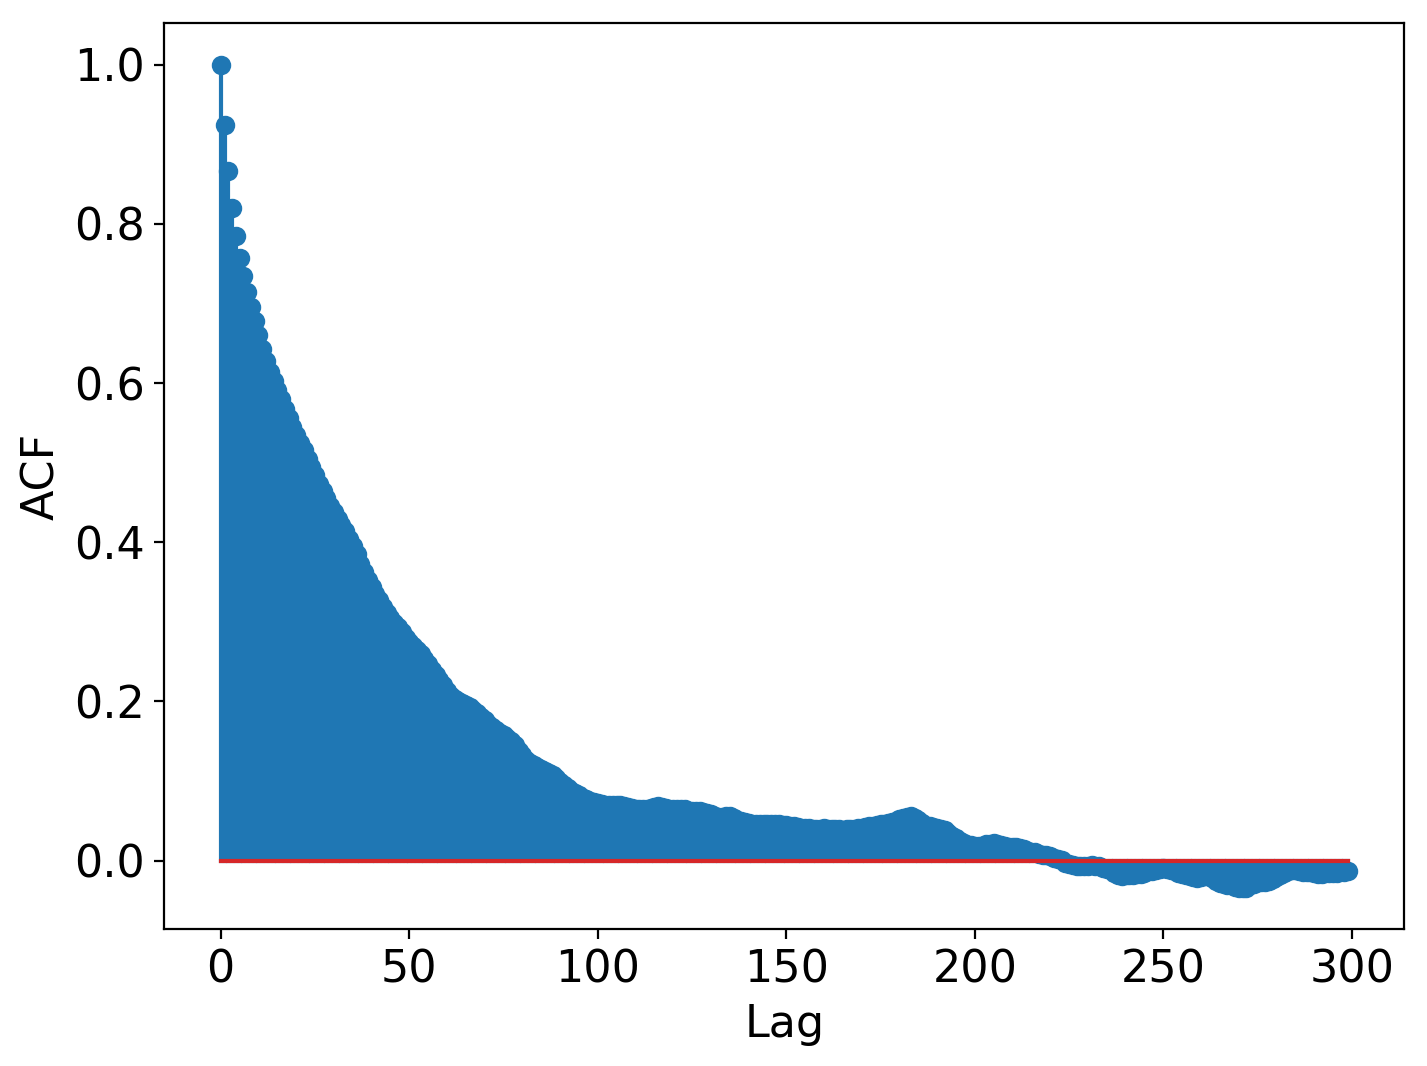

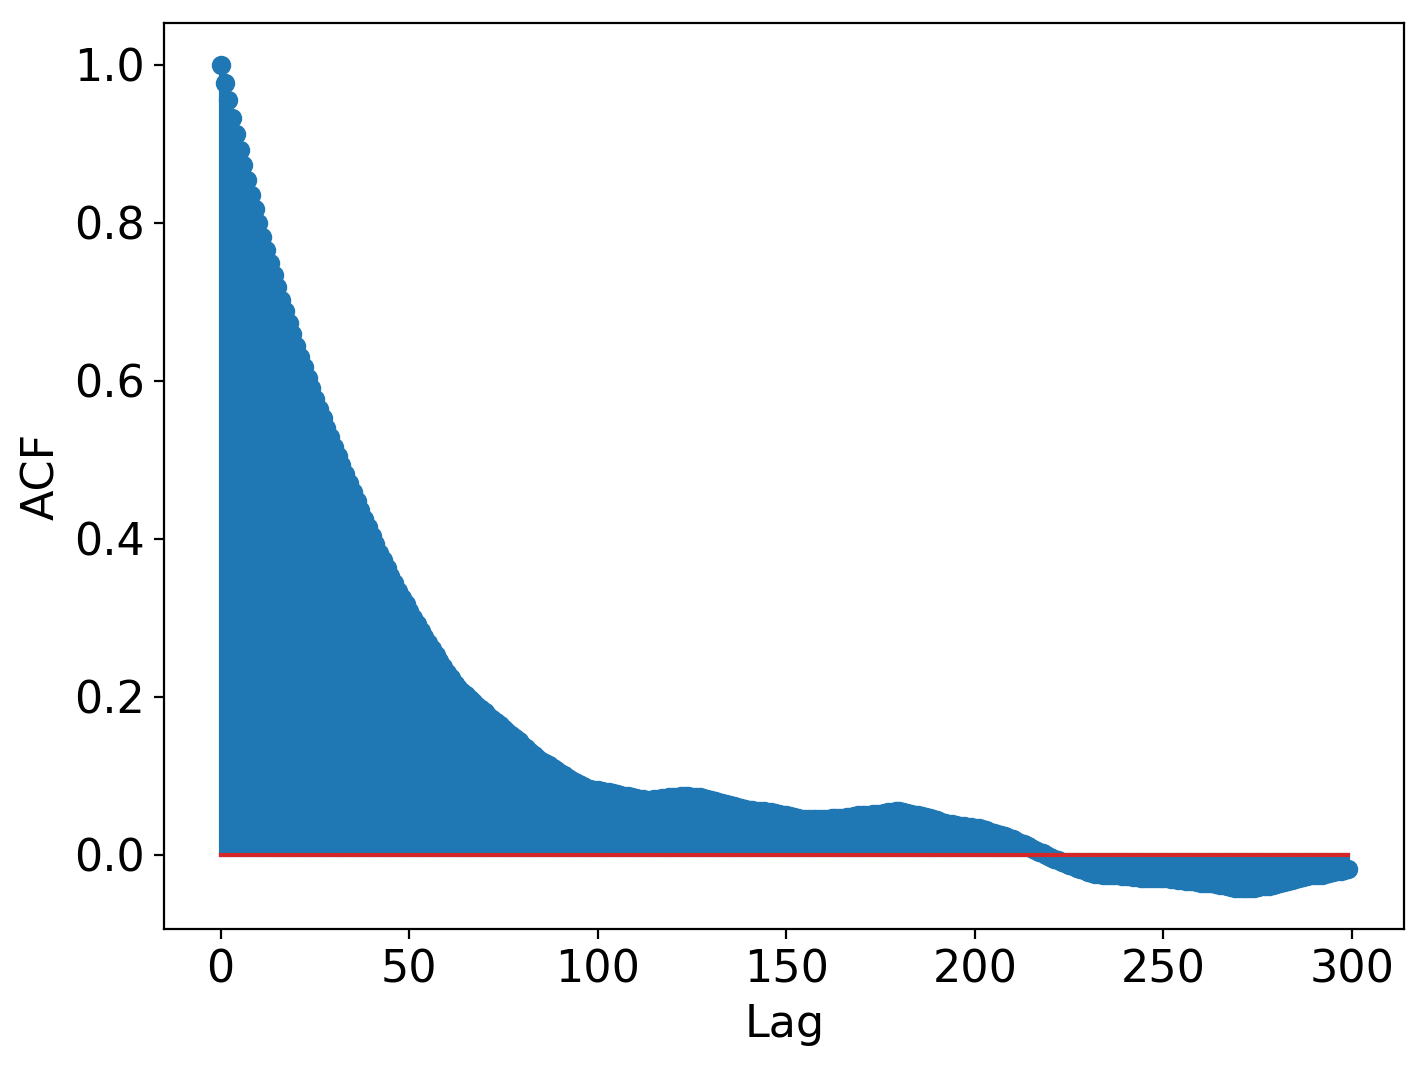

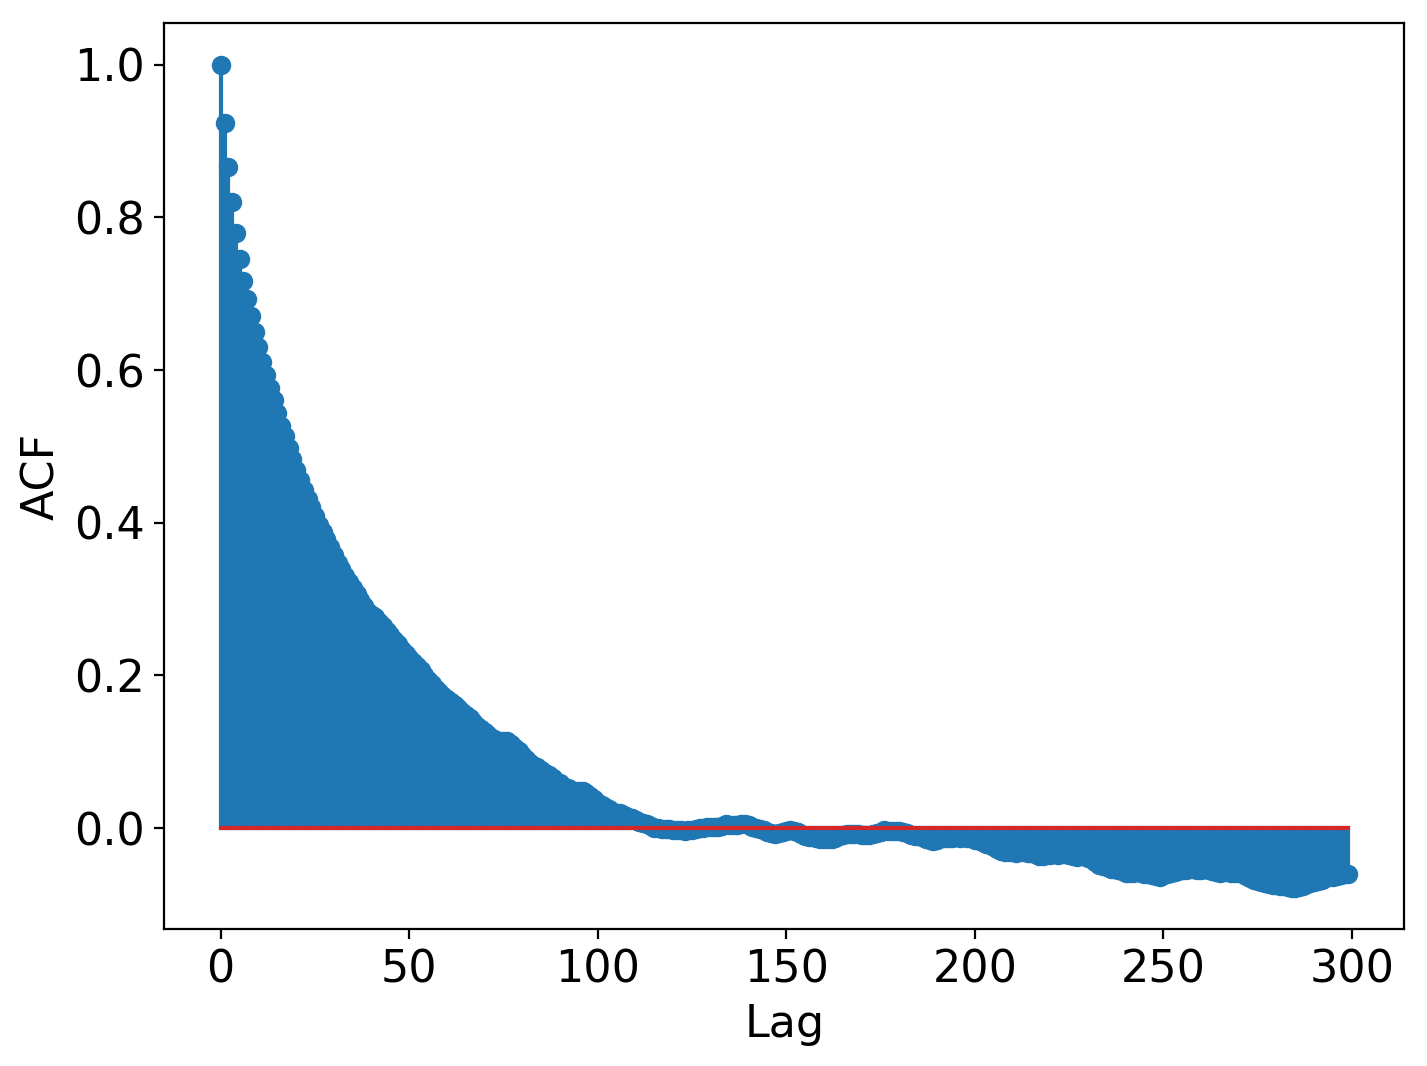

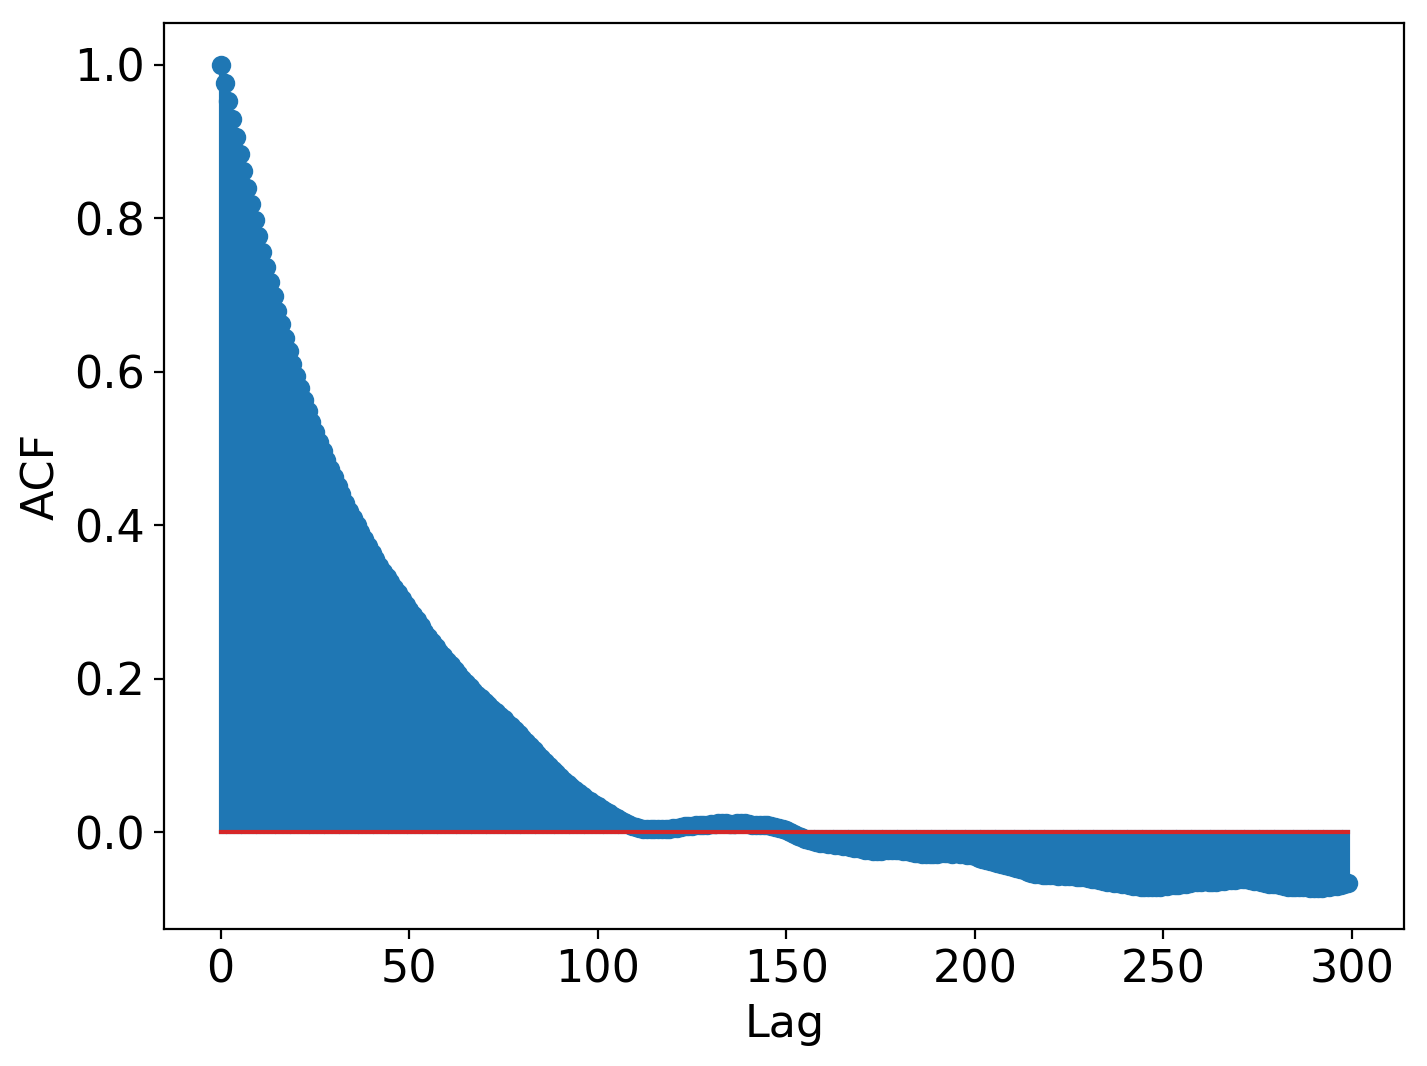

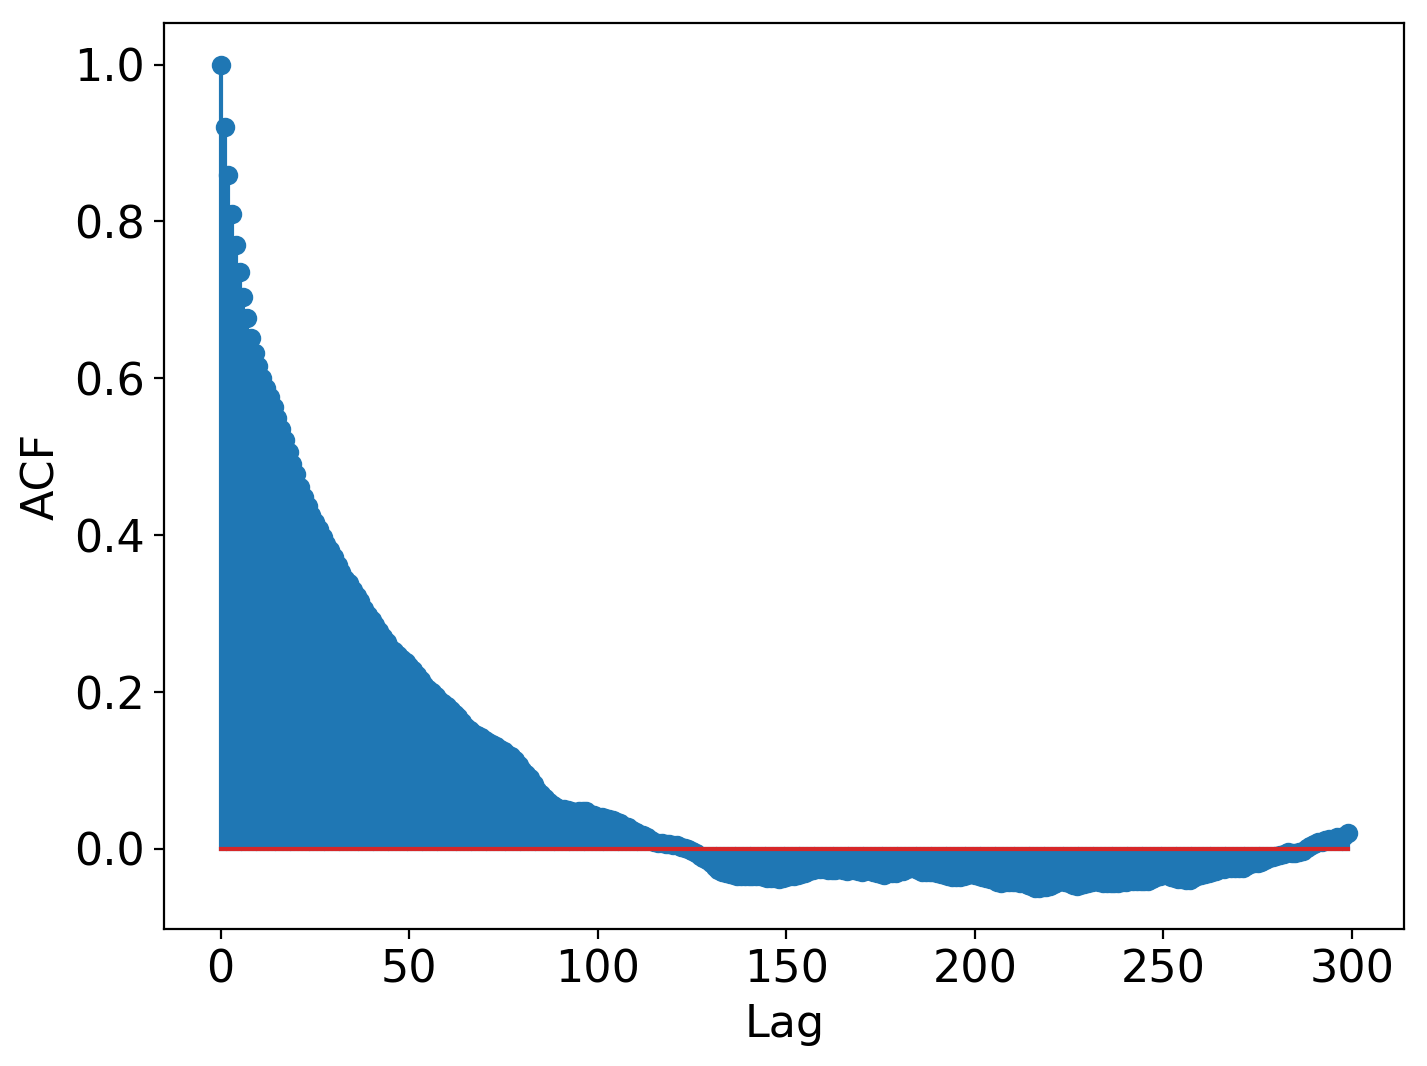

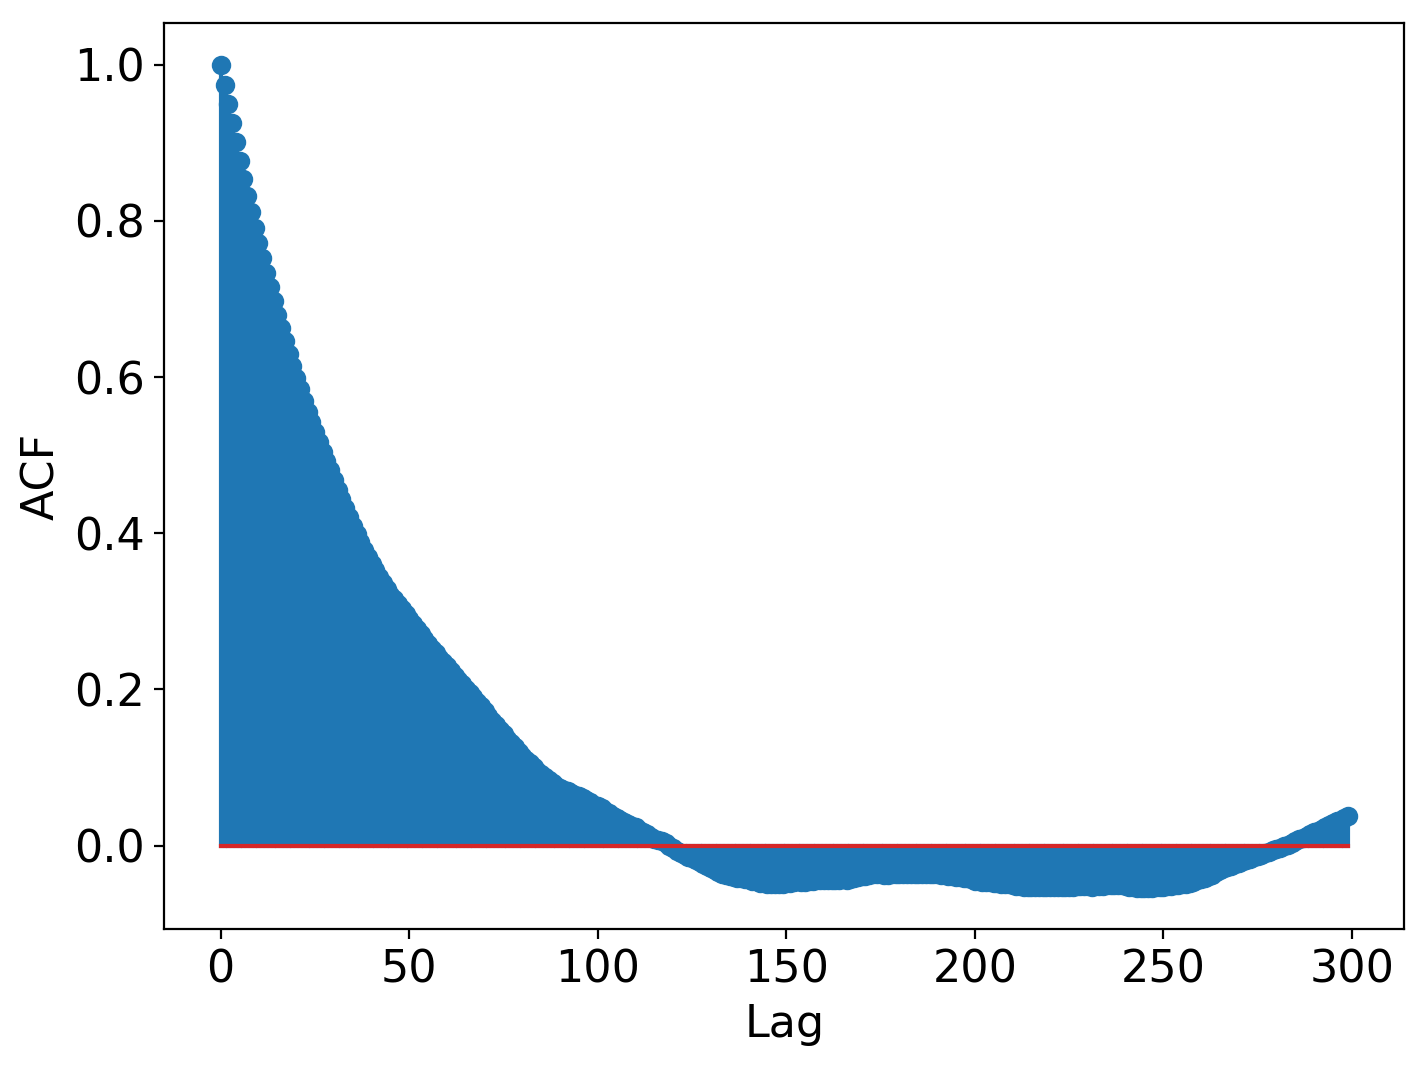

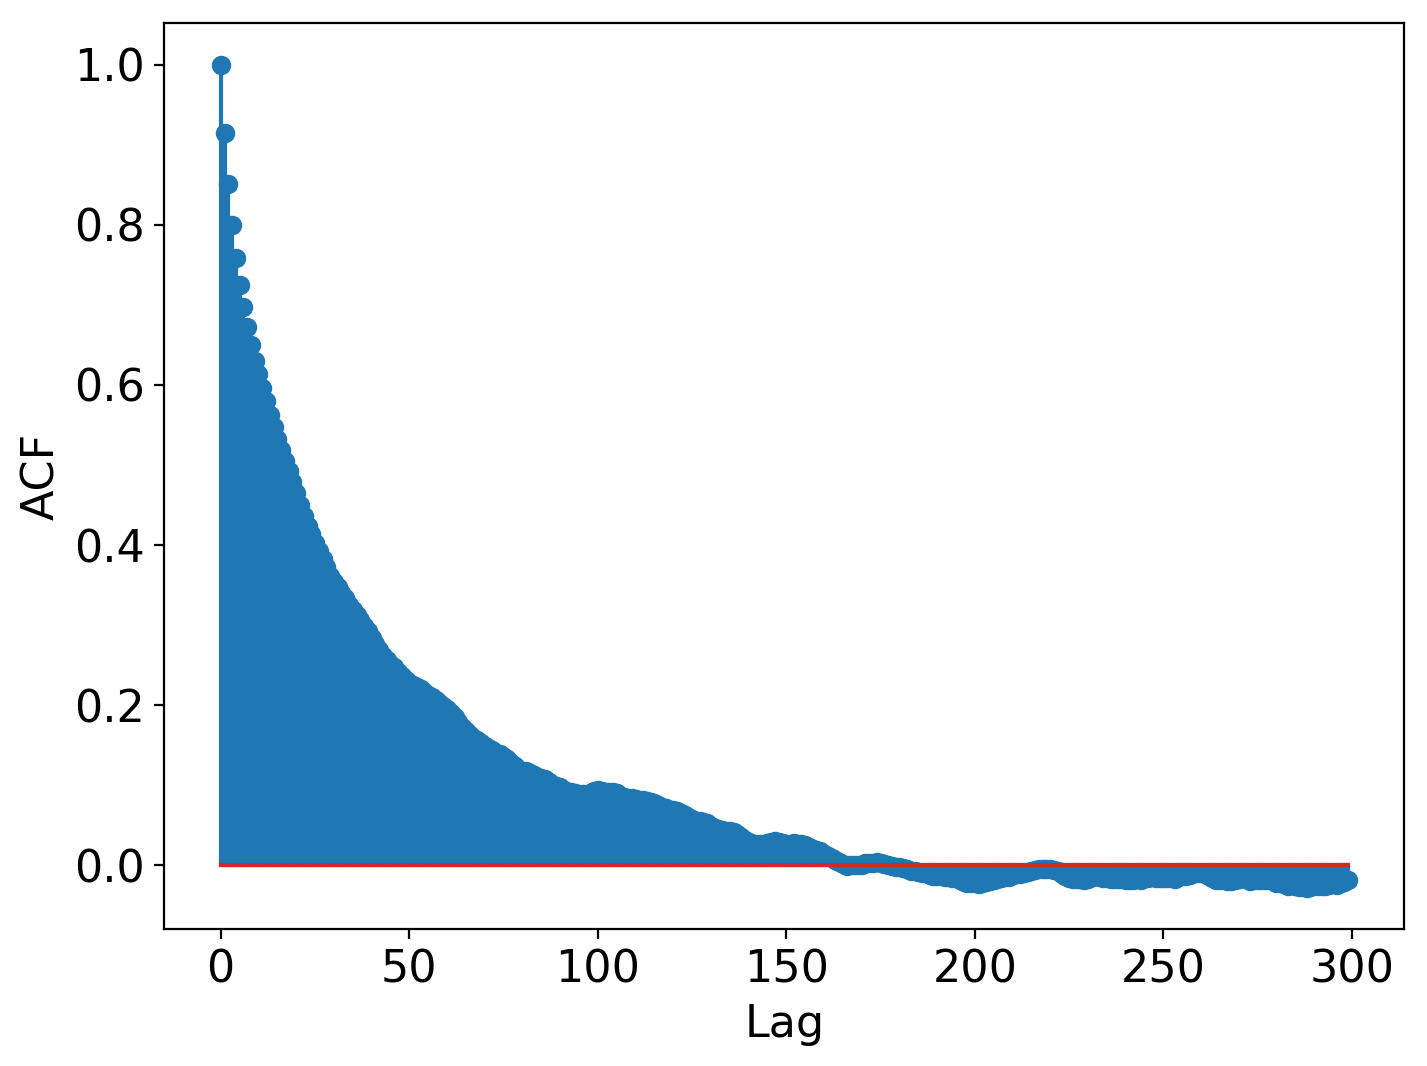

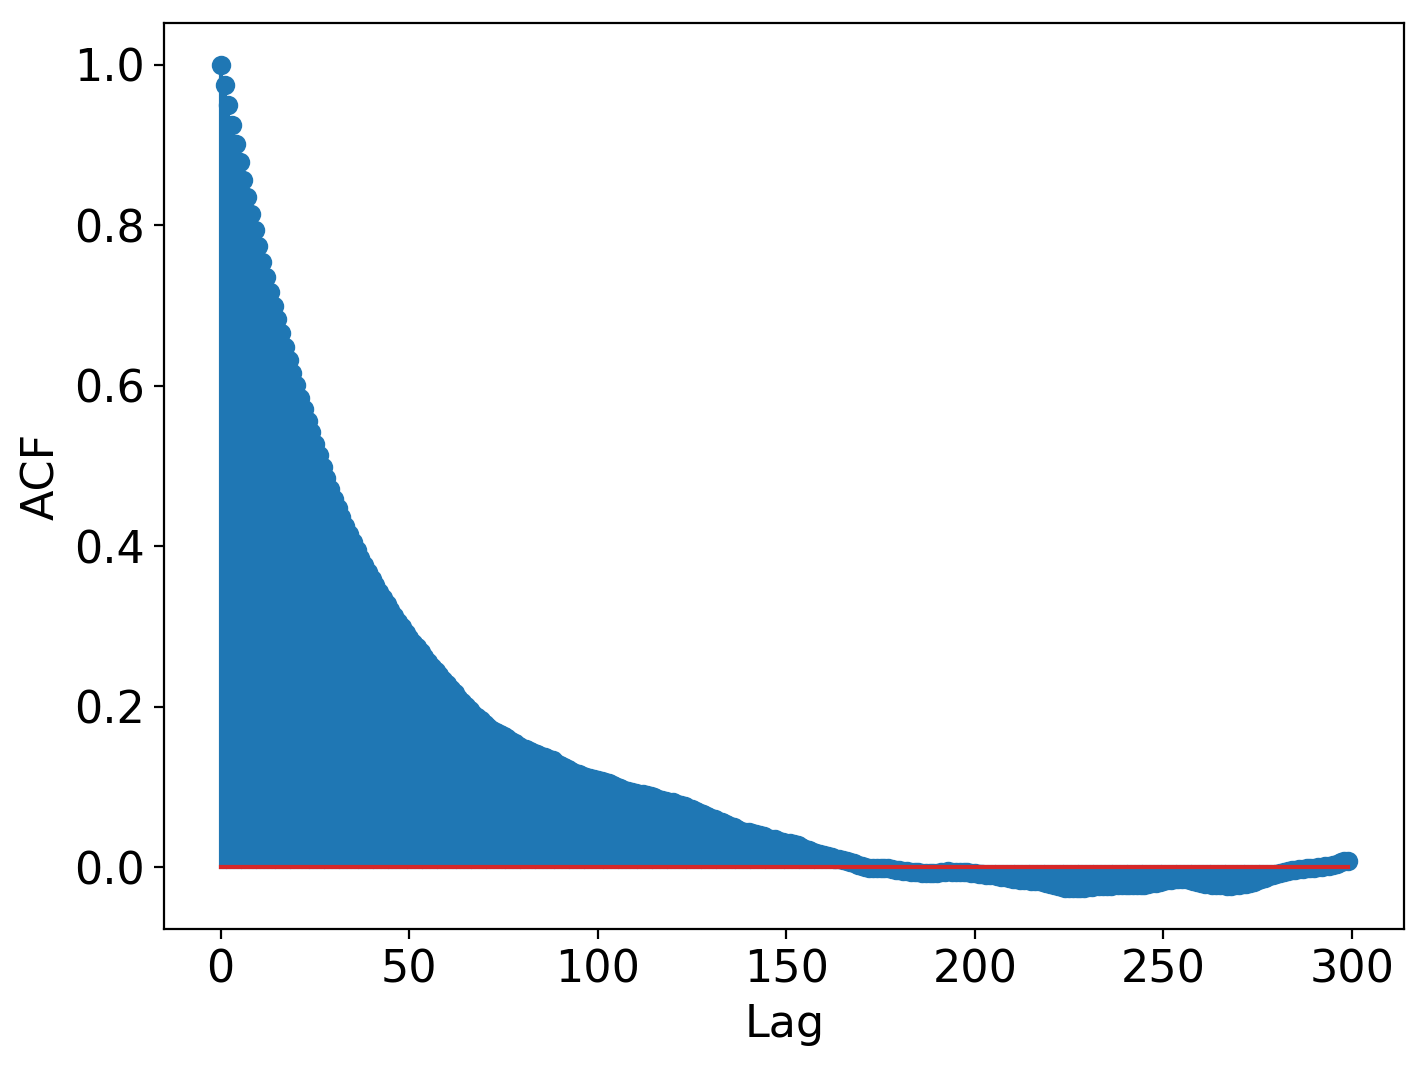

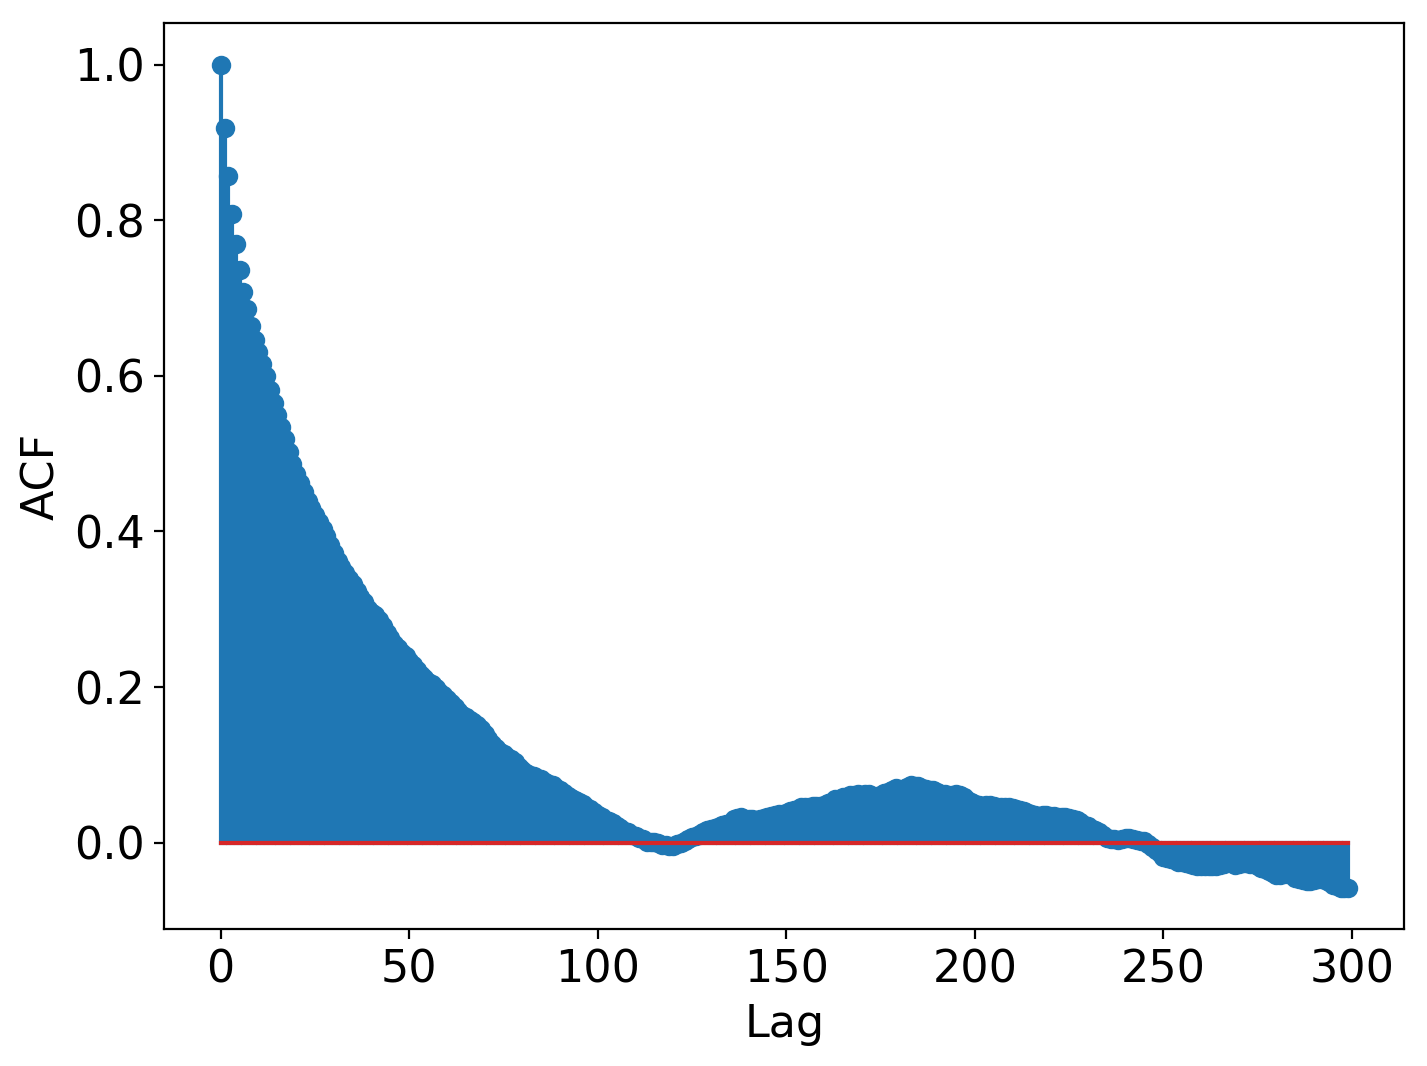

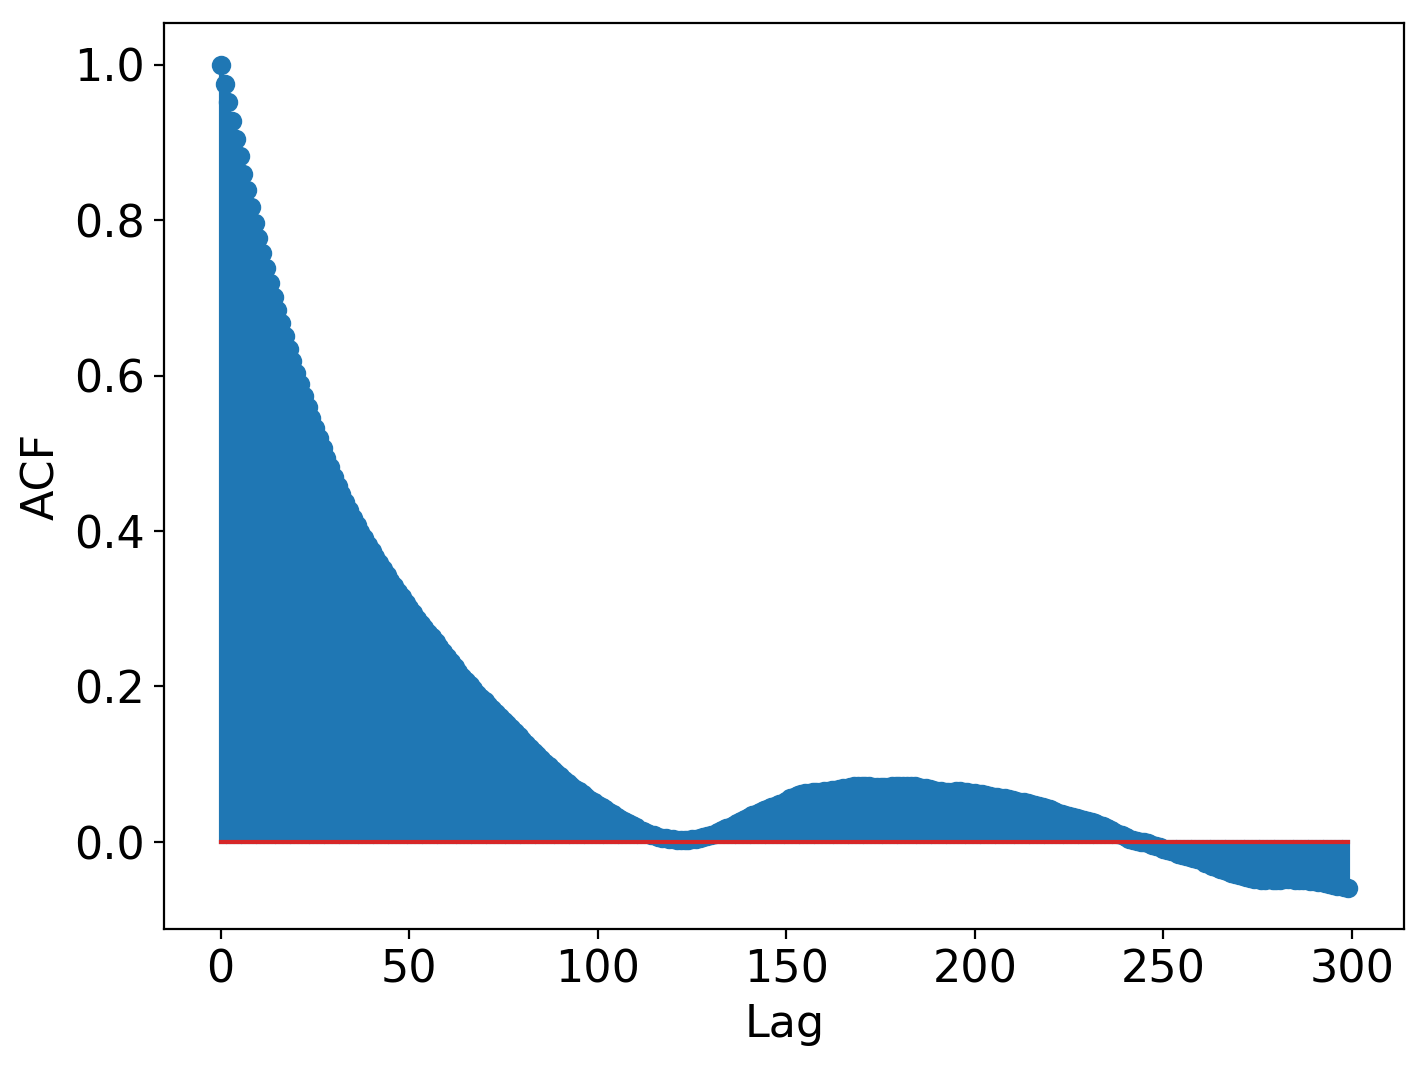

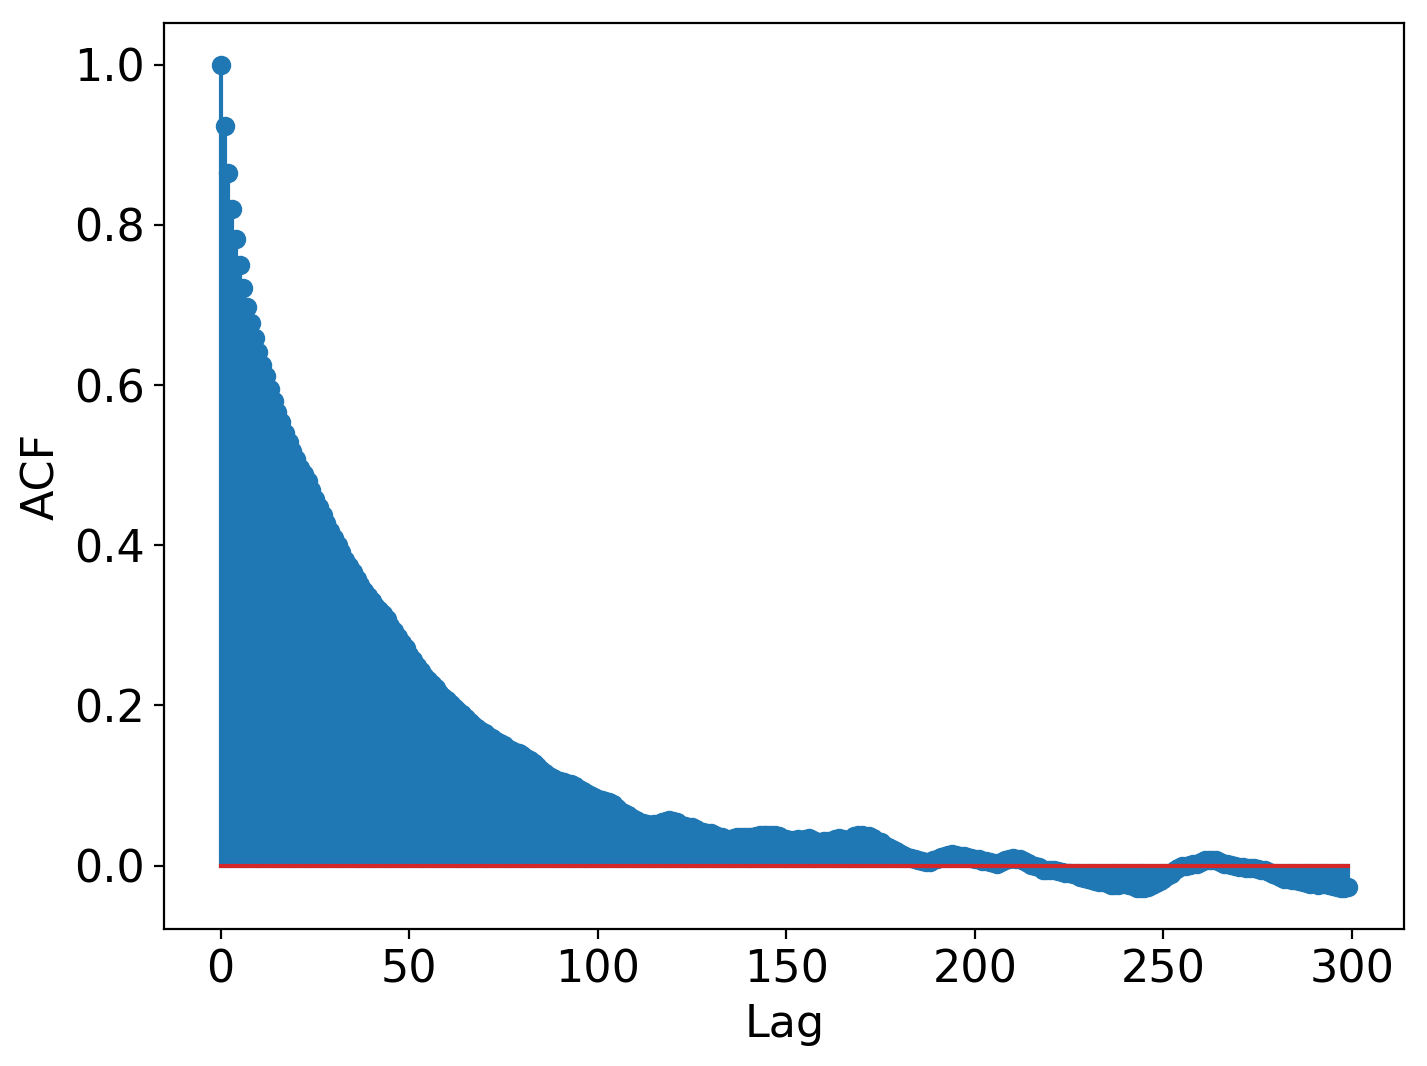

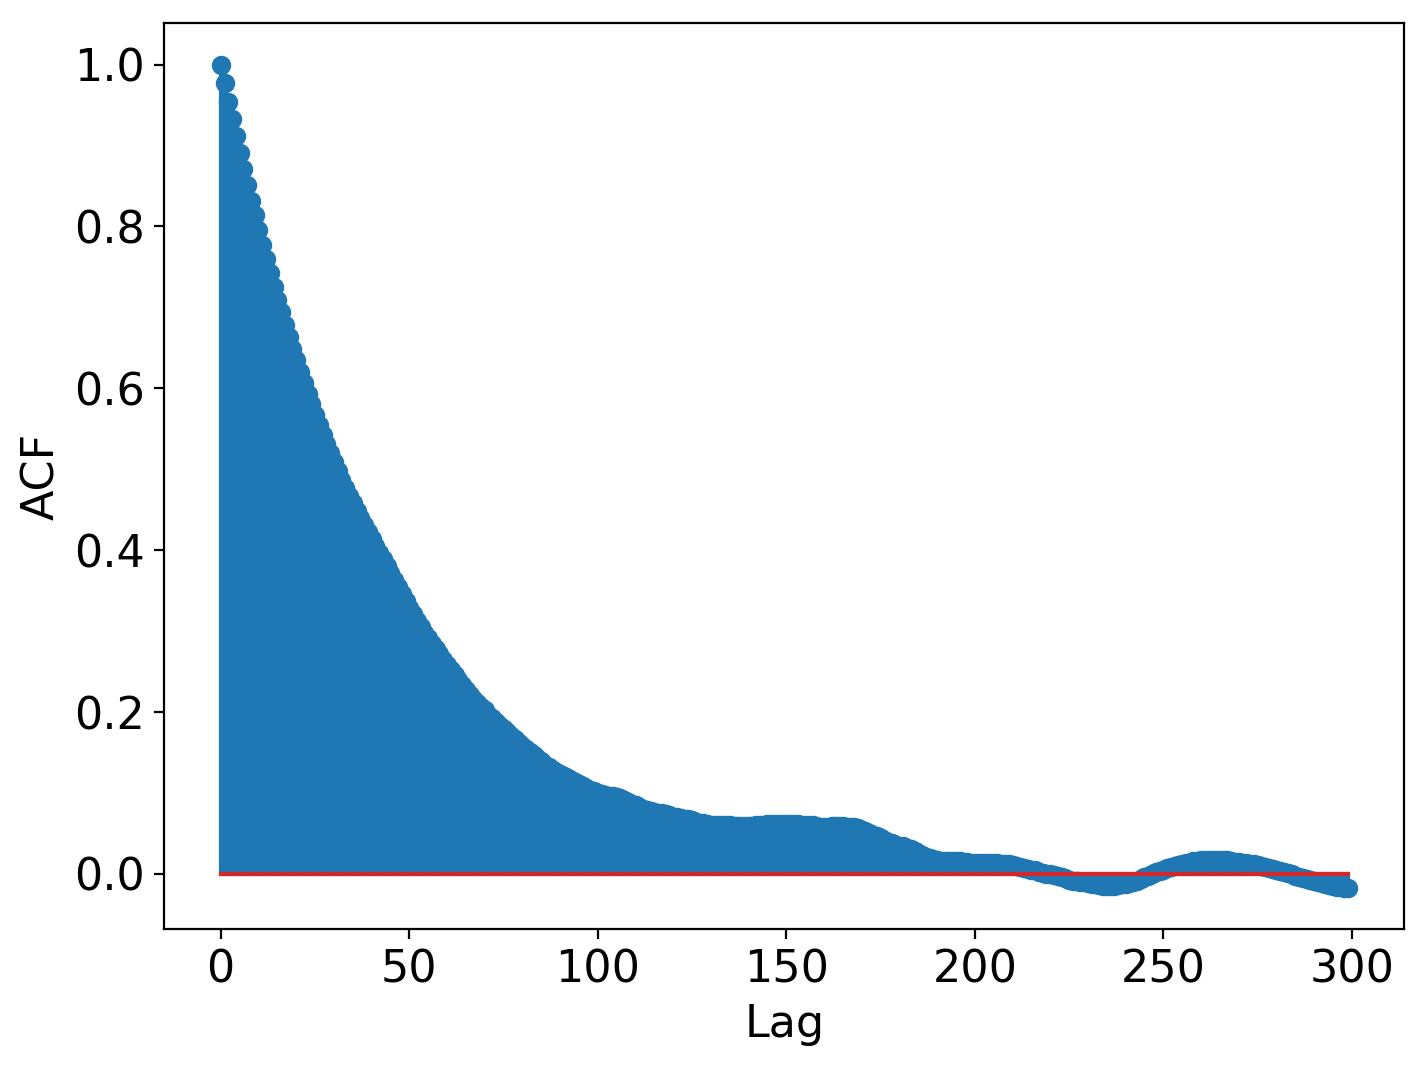

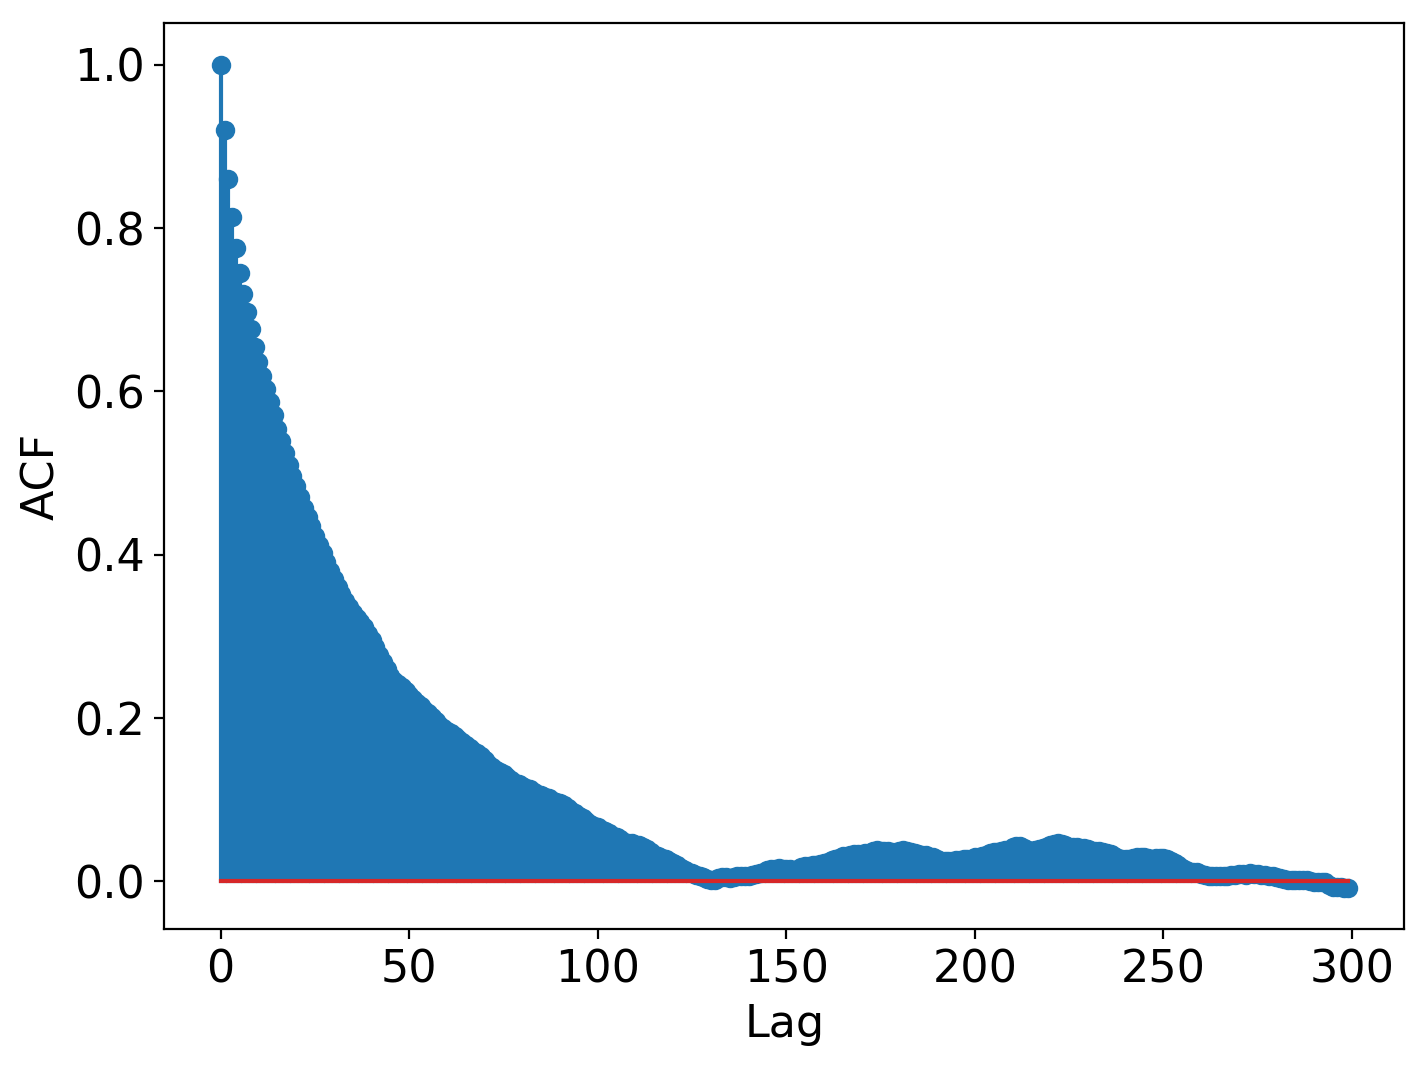

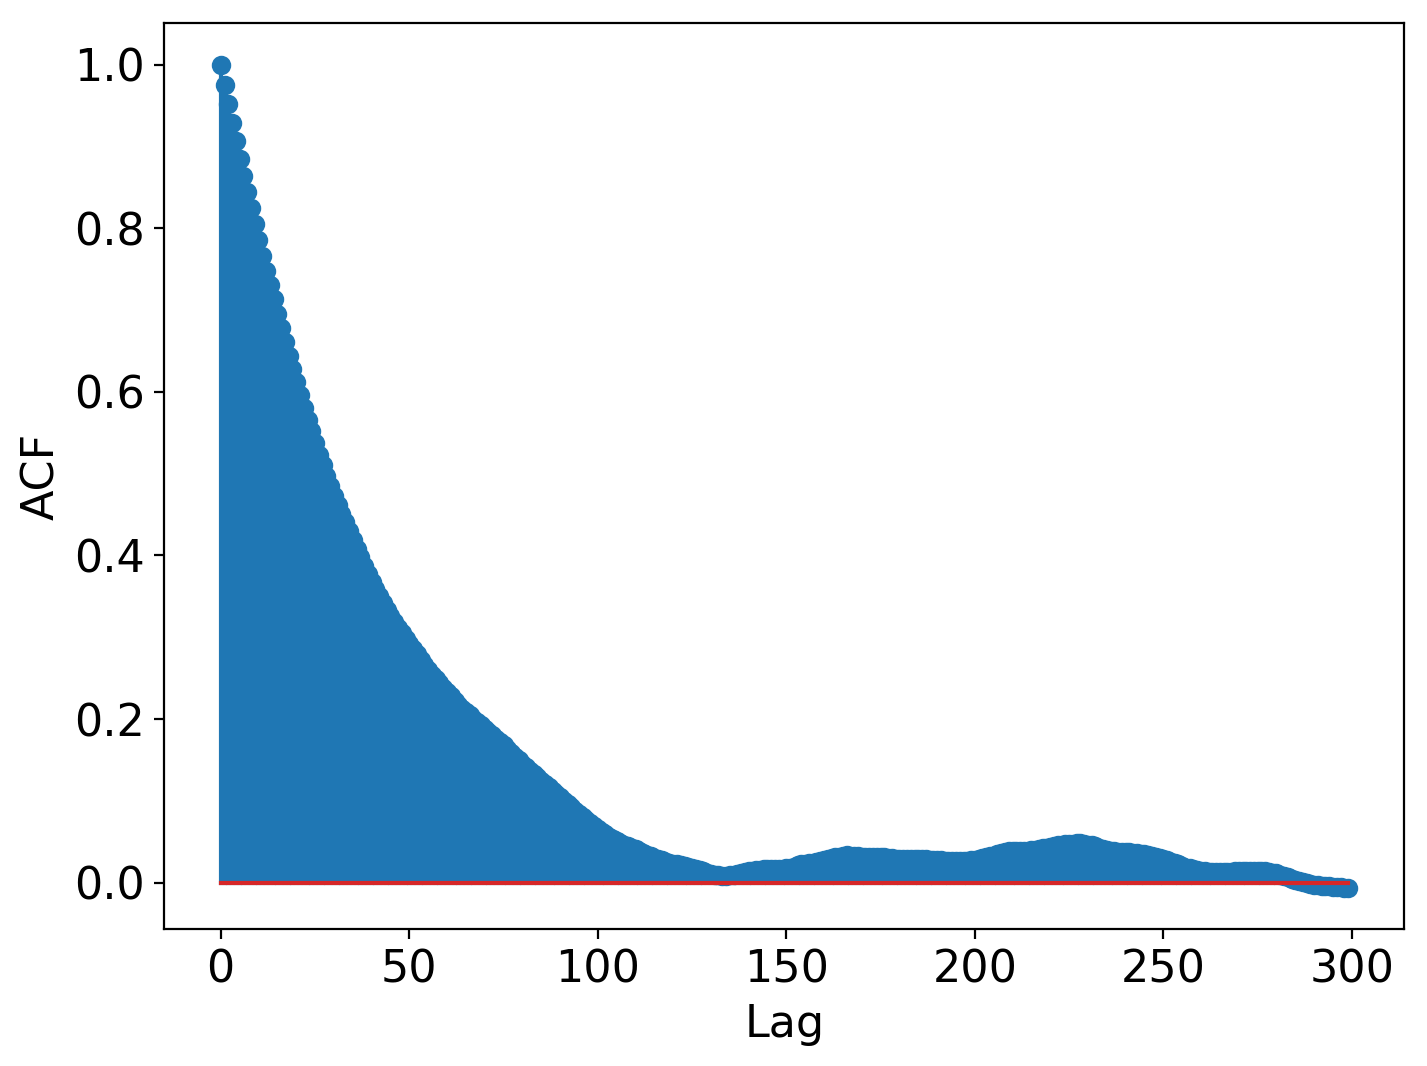

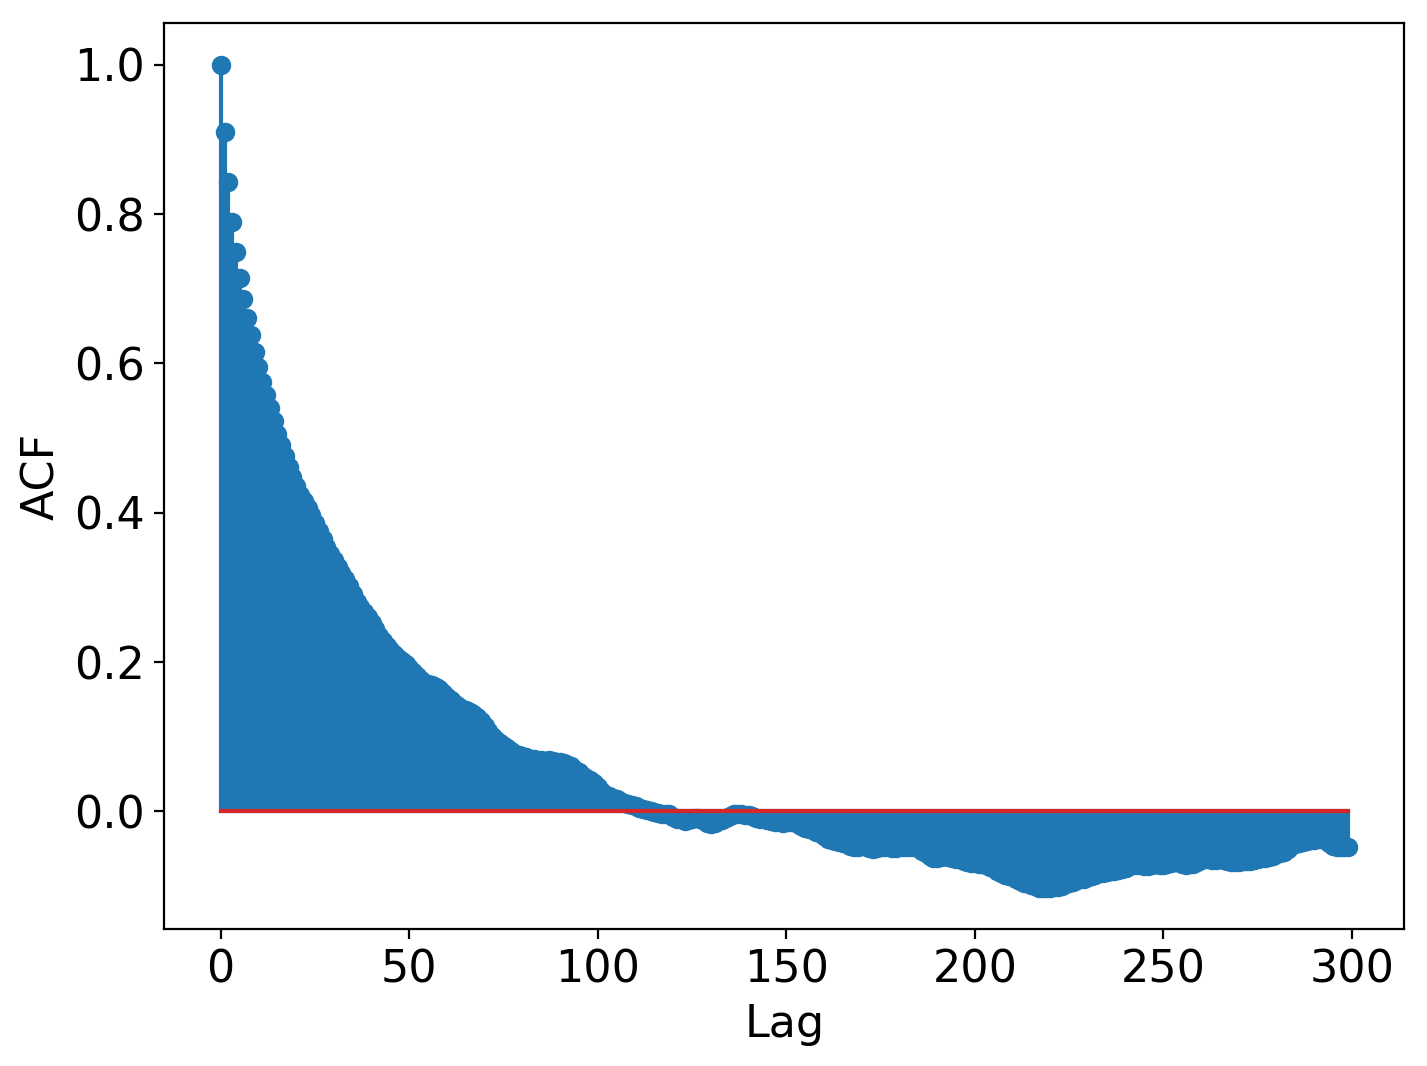

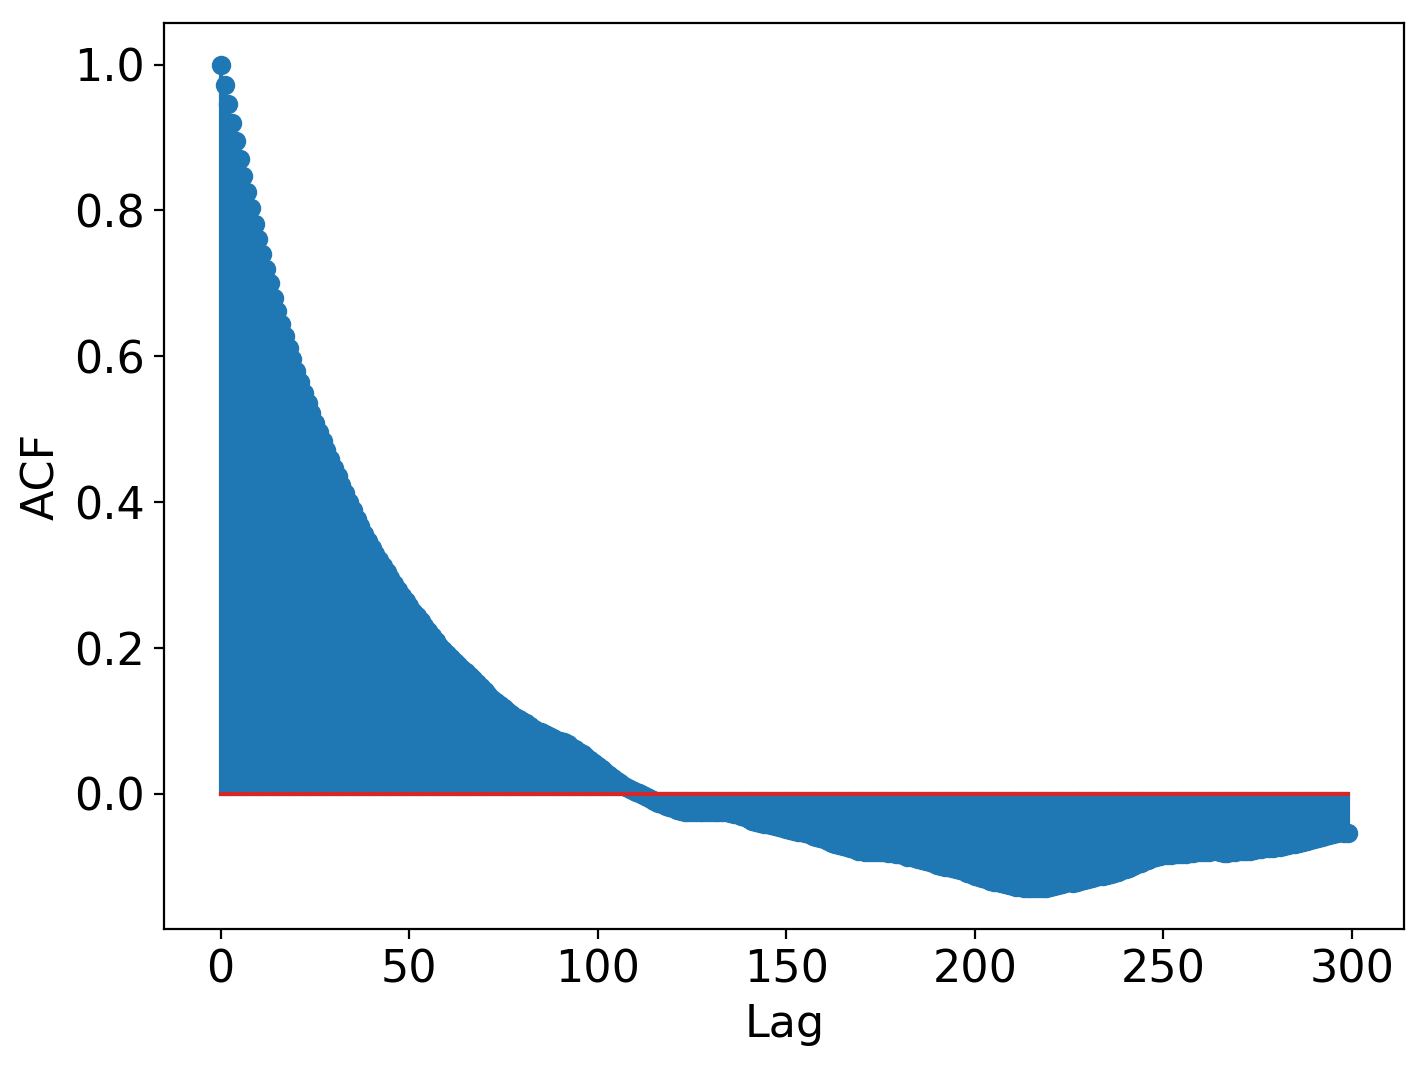

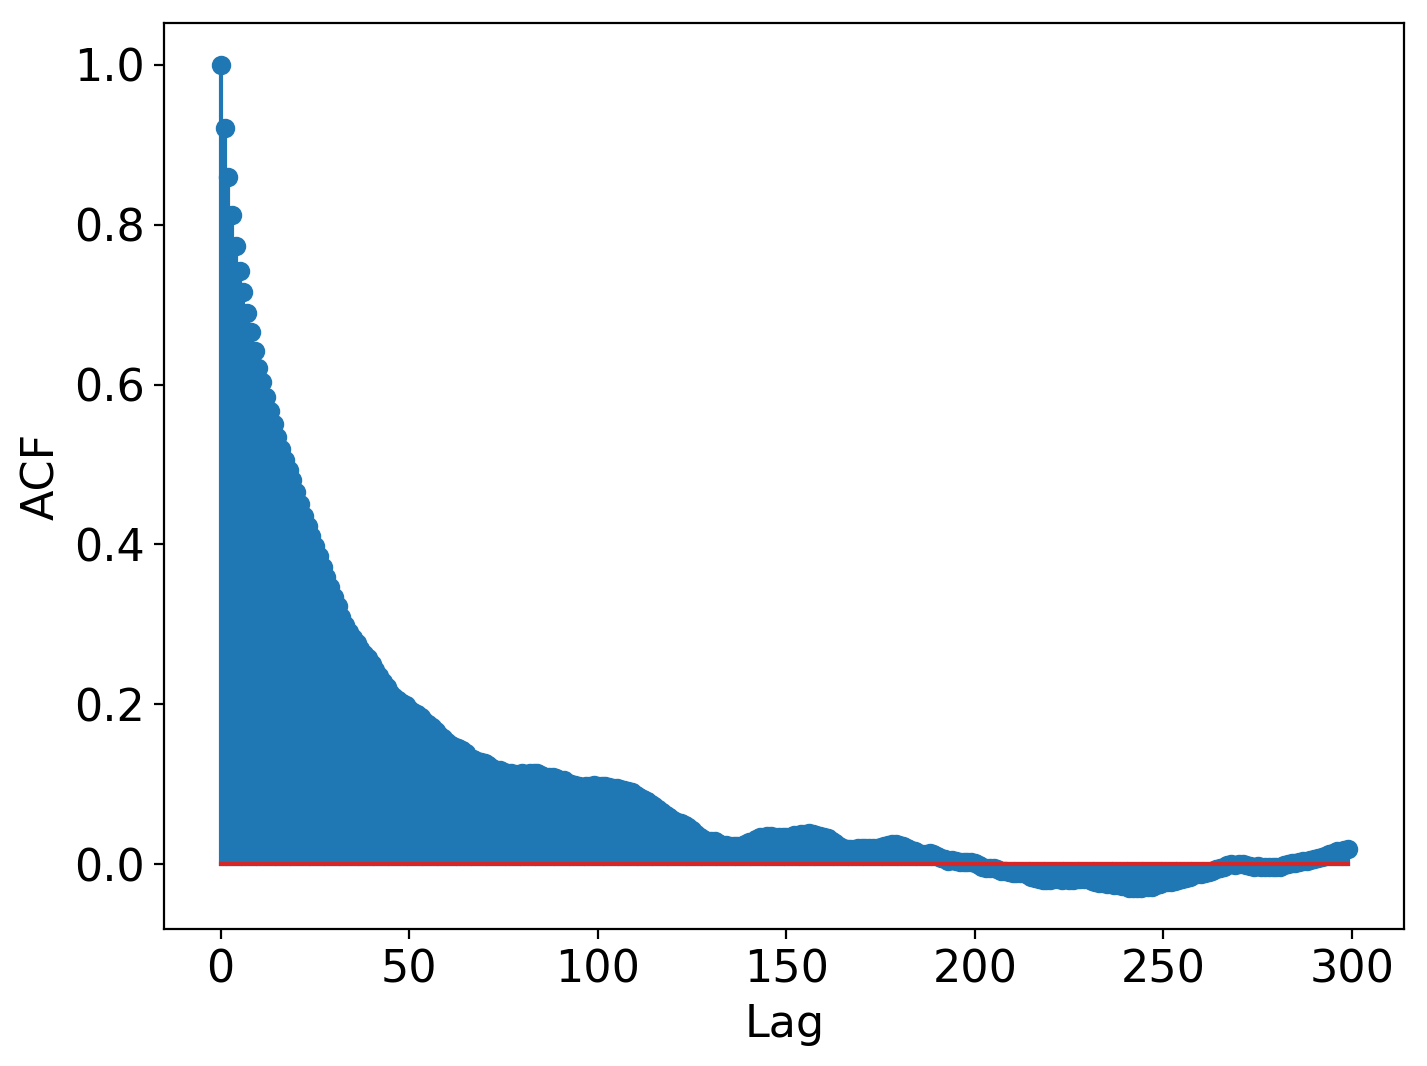

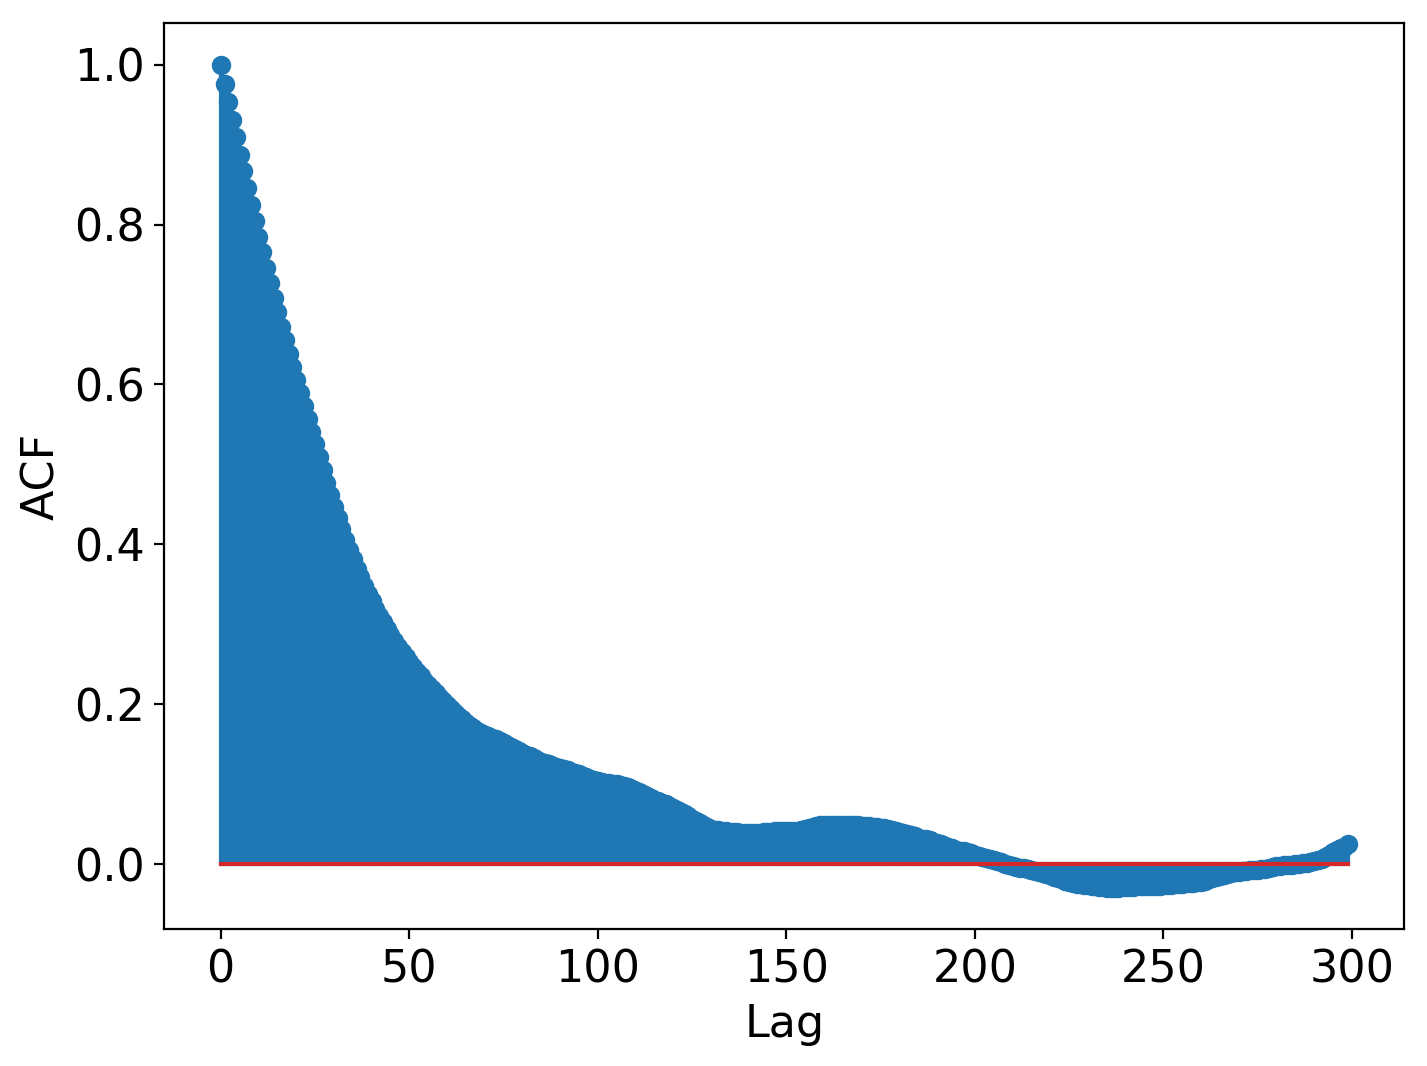

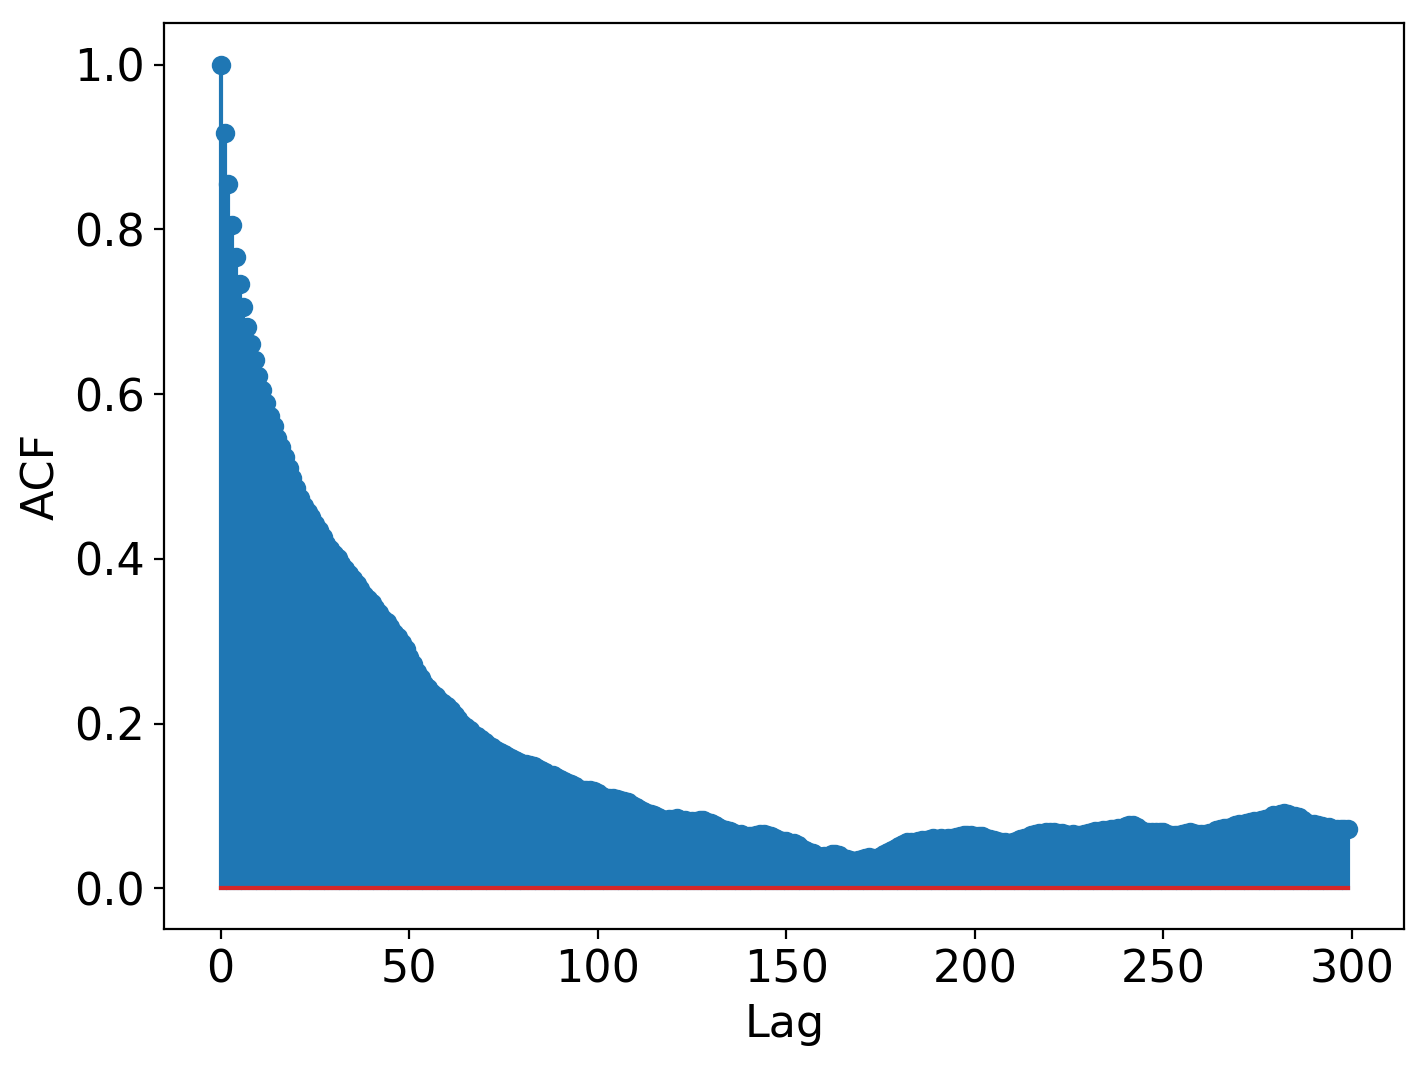

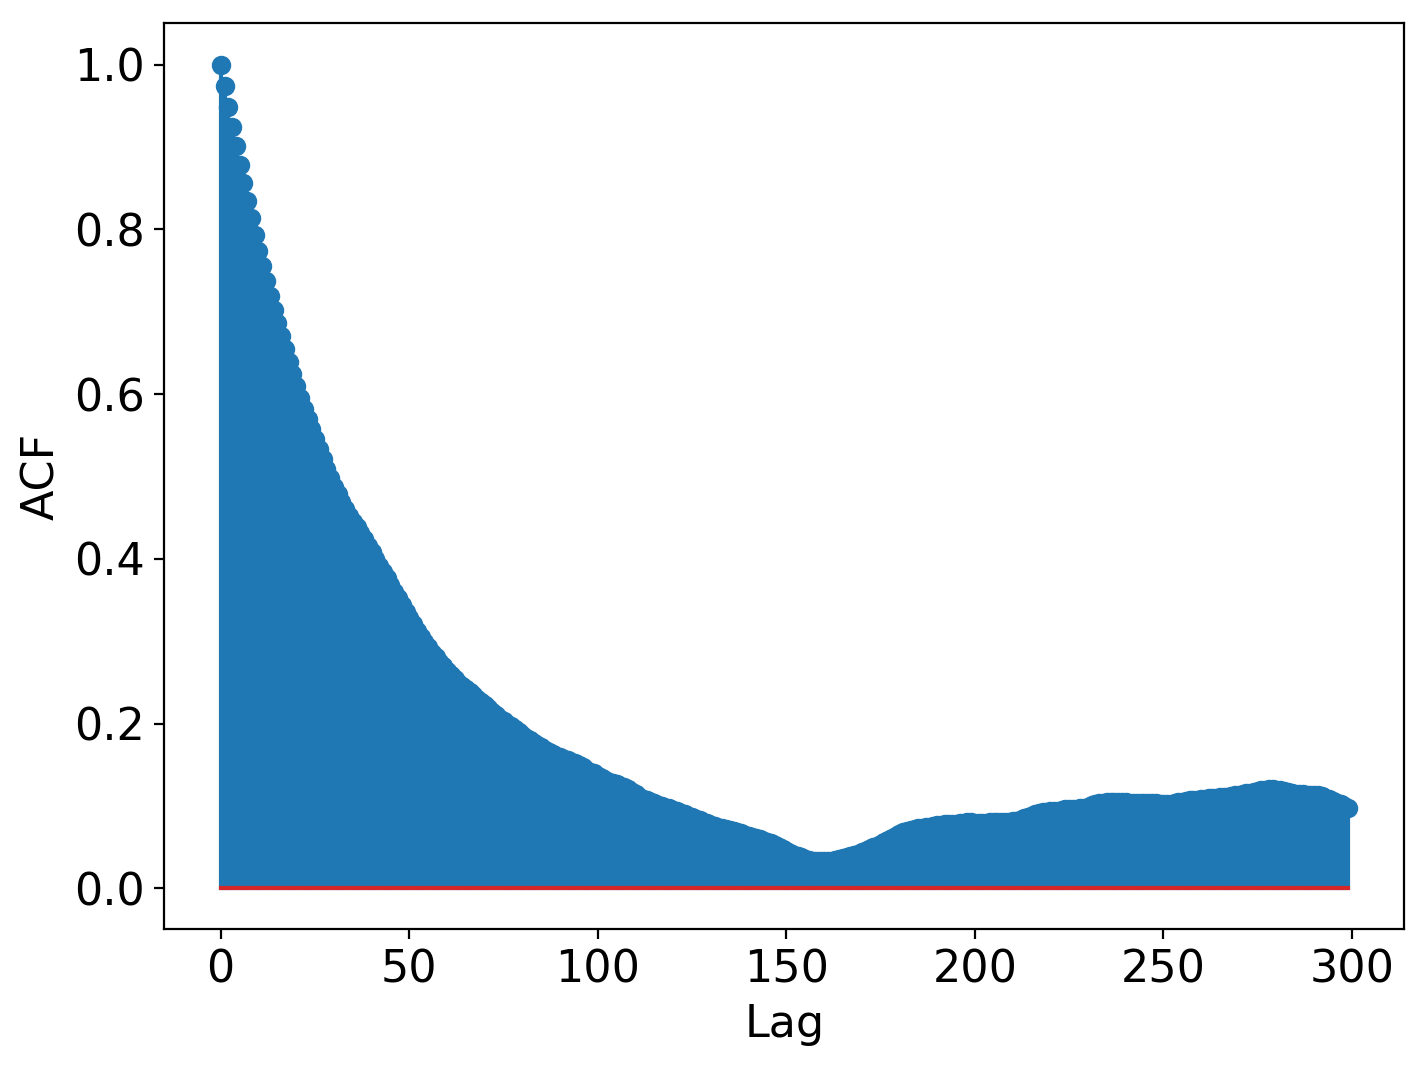

In [13]:
burnin = 10000
acf_alpha = []
acf_beta = []

for i in range(len(mcmc_chains)):
    acf_alpha.append(ACF(mcmc_chains[i, :, 0][burnin:], end=300, plot=True))
    acf_beta.append(ACF(mcmc_chains[i, :, 1][burnin:], end=300, plot=True))

<span style="color:red;font-size:25pt">**TW:**
&#x21E7; AAAAAAAAAAAAAHHHHHHHHHHHHH!!!!!!
</span>


For each chain we have a different ```lag``` value and in each chain, we have different values. We will select the largest of all these values which will ensure some level of certainty  that these values will be relatively independent when selected at these lag intervals. 

## Adaptive Metropolis Algorithm

A proper choice of a proposal distribution for MCMC methods, for example, the Metropolis-Hastings algorithm, is known to be a crucial factor for the convergence of the algorithm. In their paper, Haario etal introduce an adaptive Metropolis (AM) algorithm, where the Gaussian proposal distribution is updated during the process using all of the information accumulated so far. Due to the adaptive nature of the process, the AM algorithm is non-Markovian, but they establish that it has the correct ergodic properties.

<span style="color:red">**TW:**
Revise this to introduce the idea of step sizes being important, and relative step sizes. Note that we need a good proposal covariance matrix, and the number of elements to tune in it goes like $n^2$ where $n$ is the number of parameters to calibrate. So motivate the use of the adaptive metropolis... And simply introduce it and then reference Haario, instead of reviewing their work.
</span>

We assume that our target distribution is supported on the subset $S \subset \mathcal{R}^d$, and that it has the (unscaled) density $\pi(x)$ with respect to the Lebesgue measure on $S$. With a slight abuse of notation, we shall also denote the target distribution $\pi$. We now explain how the AM algorithm works. Remember that the basic idea is to update the proposal distribution by using the knowledge we have so far acquired about the target distribution. Otherwise the definition of the algorithm is identical to the usual Metropolis process. Suppose, therefore, that at time $t - 1$ we have the sampled states $X_0, X_1, \ldots, X_{t - 1}$, where $X_0$ is the initial state. Then a candidate point $Y$ is sampled from the (asymptotically symmetric) proposal distribution $q_t(. \mid X_0, \ldots, X_{t - 1})$, which now depend on the whole history $(X_0, X_1, \ldots, X_{t - 1})$. The candidate point $Y$ is accepted with probability

$$
\alpha\left(X_{t - 1}, Y\right) = \text{min}\left(1, \frac{\pi(Y)}{\pi(X_{t - 1})}\right)
$$

(**This part was adapted from Haario etal 2001**)

<span style="color:red">**TW:**
Looks like the code below can be cleaned up in a manner consistent with the original codes above. $$$$ Make sure that the MCMC_chains code is **exactly** the same, except for a single line that updates the covariance, and just have a single helper function that does the update (update_cov)  $$$$ Use the resulting covariance matrix from this to inform a crude estimate for the "just right" step sizes in the motivation and acceptance rate discussion above. Pick something closer to the adapted covariance, because the one giving 26% acceptance above still looks a little rough.
</span>


In [14]:
eps = 0.0001
d = 2
I_d = np.identity(d)
S_d = (2.4) ** 2 / 2

def update_cov(X, d=2, s_d=S_d, eps=0.0001, i_d=I_d):
    cov = np.cov(X)
    return s_d * cov + i_d * eps * s_d

def MCMC_chains(y, step, N=30_000, isPlot=False):
    # randomly generate starting positions.
    alpha_init = np.random.randint(low=0, high=1)
    beta_init = np.random.randint(low=0, high=10)
    theta = [alpha_init, beta_init]
    # set variables.
    lp = logpost(theta, y)
    theta_best = theta
    lp_max = lp
    theta_new = [0] * 2
    accepts = 0
    mcmc_chains = [[0, 0]] * N
    # run the mcmc chain.
    for i in range(N):
        step = update_cov(step)
        theta_new = list(stats.multivariate_normal.rvs(theta, step))
        lp_new = logpost(theta_new, y)
        lq = lp_new - lp
        lr = np.log(np.random.uniform(0, 1))
        if lr < lq:
            theta = theta_new
            lp = lp_new
            accepts += 1
            if lp > lp_max:
                theta_best = theta
                lp_max = lp
        mcmc_chains[i] = theta
    mcmc_chains = np.array(mcmc_chains)
    # print the acceptance ratio.
    ar = (accepts / N) * 100
    print(f"Acceptance Rate ≈ {ar:.4f}%")
    # plot!
    if isPlot:
        # History Plots
        fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 4))
        fig.tight_layout()
        ax[0].plot(mcmc_chains[:, 0], linewidth=0.30, color="k")
        ax[0].set_title("History Plots")
        ax[0].set_ylabel(r"$\alpha$")
        ax[1].plot(mcmc_chains[:, 1], linewidth=0.30, color="steelblue")
        ax[1].set_ylabel(r"$\beta$")
        # Alpha Histogram
        plt.figure()
        plt.hist(mcmc_chains[:, 0], 100, color="k", histtype="step")
        plt.xlabel(r"$\alpha$")
        plt.ylabel(r"$p(\alpha)$")
        plt.gca().set_yticks([])
        plt.show()
        # Beta Histogram
        plt.figure()
        plt.hist(mcmc_chains[:, 1], 100, color="k", histtype="step")
        plt.xlabel(r"$\beta$")
        plt.ylabel(r"$p(\beta)$")
        plt.gca().set_yticks([])
        plt.show()
    # return the mcmc chain.
    return mcmc_chains

Acceptance Rate ≈ 69.5733%


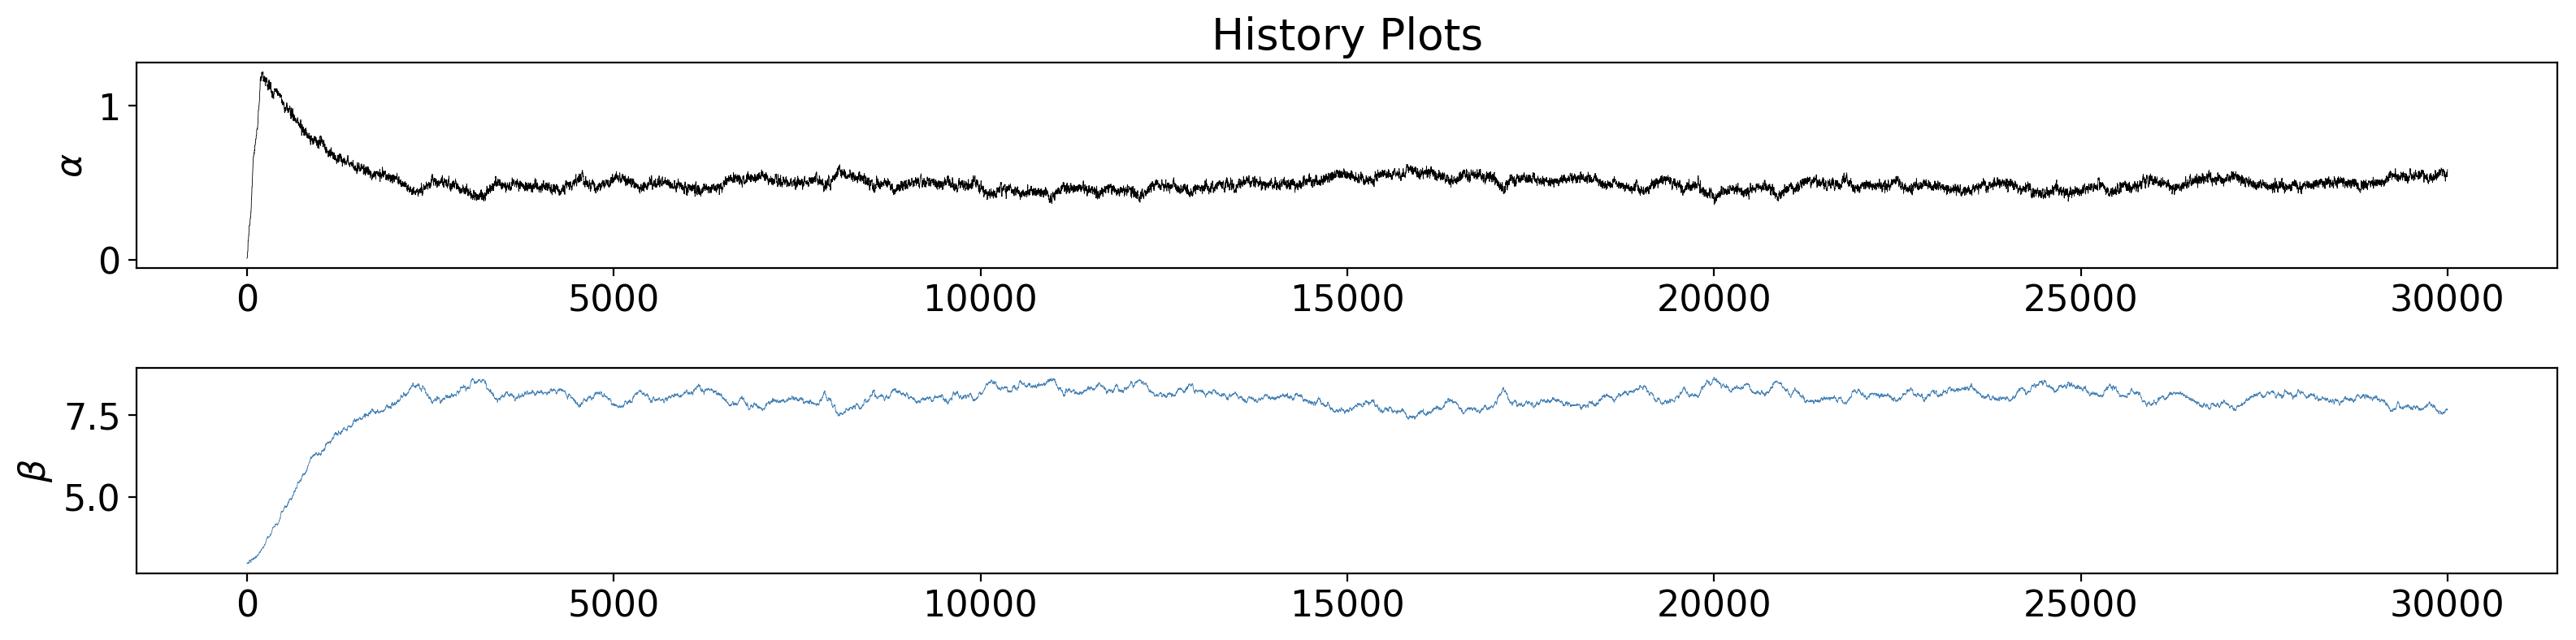

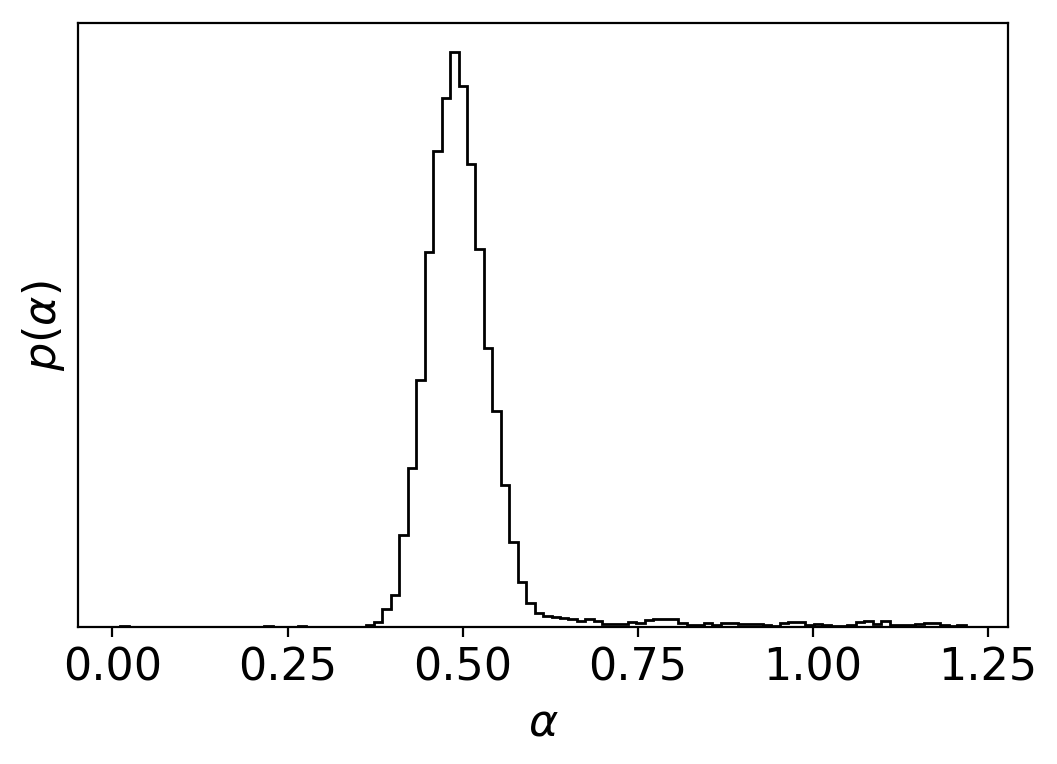

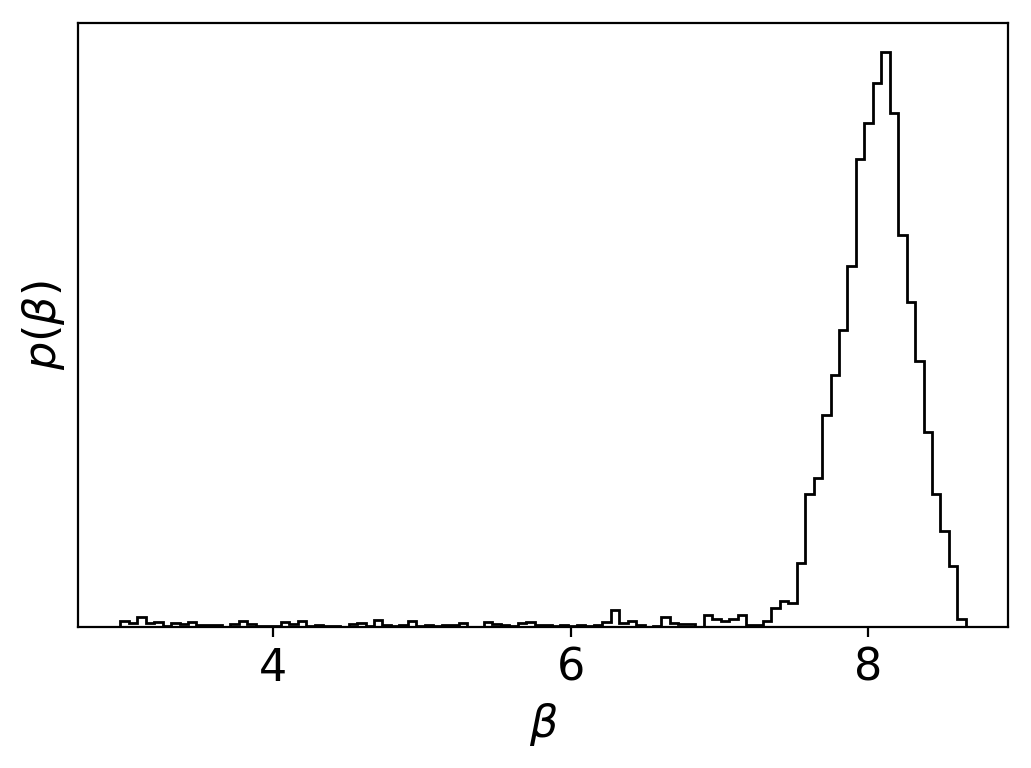

In [15]:
mcmc_chains = MCMC_chains(y_meas, step=[0.005, 0.01], isPlot=True)

In [16]:
alpha_raw2 = []
beta_raw2 = []

for i in range(len(chains2)):
    alpha_raw2.append(chains2[i]["alpha"])
    beta_raw2.append(chains2[i]["beta"])

GR_alpha2 = GR_diag(alpha_raw2, interval=500)
GR_beta2 = GR_diag(beta_raw2, interval=500)

NameError: name 'chains2' is not defined

In [ ]:
burnin2 = 10000

acf_alpha2 = []
acf_beta2 = []

for i in range(len(chains2)):
    acf_alpha2.append(ACF(chains2[i]["alpha"][burnin2:], end=200))
    acf_beta2.append(ACF(chains2[i]["beta"][burnin2:], end=200))